In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import gridspec
from matplotlib import patches
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D

import os
import math
import random

import keras
from keras.models import Sequential
from keras.layers import Input, Dense, Conv1D, Conv2D, Flatten, MaxPooling1D, MaxPooling2D
from keras.layers import Dropout
from keras.callbacks import EarlyStopping

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn import preprocessing
from sklearn.metrics import roc_curve, roc_auc_score, auc

import scipy.stats as st
from scipy.stats import poisson
from scipy.interpolate import interp1d
from scipy.stats import norm

In [2]:
from sklearn.neighbors import KernelDensity # paquete necesario
from sklearn.model_selection import GridSearchCV

import scipy.integrate as integrate

In [3]:
!pip install xgboost

import xgboost
from xgboost import XGBRegressor, XGBClassifier

You should consider upgrading via the '/home/andres/anaconda3/bin/python -m pip install --upgrade pip' command.


In [4]:
import h5py

import glob
import numpy as np
import os.path as path
import imageio
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Activation, Dropout, Flatten, Dense, Conv2D, MaxPooling2D
from keras.callbacks import EarlyStopping, TensorBoard
from datetime import datetime
import keras
from keras import regularizers
from sklearn.model_selection import train_test_split
import pandas as pd
from sklearn.metrics import accuracy_score, f1_score, average_precision_score, precision_recall_curve, auc,recall_score
#from keras.optimizers import Adam
from keras.regularizers import l2
import h5py
from sklearn.model_selection import GridSearchCV
from keras.backend import cast, greater, clip, floatx,epsilon
from keras.wrappers.scikit_learn import KerasClassifier
from keras import backend as K
from sklearn.model_selection import StratifiedKFold

### Load Data

In [7]:
filefolder = '../../data2024/processed/'

###################
# BACKGROUND FILE #
###################

filename_B = 'ER/ER_all.hdf5'


###############
# SIGNAL FILE #
###############

# select the DM mass
mDM = 500

filename_S = 'mDM' + str(mDM) + 'GeV/WP_mDM' + str(mDM) + 'GeV_sig1045.hdf5'

##### Load the h5

In [8]:
# OPEN THE SAVED FILE TO CHECK IT
f_B = h5py.File(filefolder+filename_B,'r')
f_S = h5py.File(filefolder+filename_S,'r')

# show the groups
print( f_B.keys() )

# should be more than 10k events in each group
print('\n Background Events: ')
for groups1 in f_B.keys():
    print(len(f_B[groups1].keys()))

print('\n Signal Events')
for groups1 in f_S.keys():
    print(len(f_S[groups1].keys()))

<KeysViewHDF5 ['HITS_bot', 'HITS_bot_img', 'HITS_top', 'HITS_top_img', 'peakS1_onlyhits', 'peakS1_raw', 'peakS2_onlyhits', 'peakS2_raw']>

 Background Events: 
35549
35549
35549
35549
35549
35549
35549
35549

 Signal Events
32015
32015
32015
32015
32015
32015
32015
32015


In [9]:
################
# ALL THE DATA #
################


# to normalize
scaler = preprocessing.MinMaxScaler()

# Number of data points (per-class) for the ML classifier
#num_data = 30000
num_data = 5000


In [10]:
###################
# peakS1_onlyhits #
###################

# First:
# The max len for the time series

max_pS1_B = 0
max_pS1_S = 0

for i in range(1, num_data+1):
    max_pS1_B = max(max_pS1_B, len( f_B['peakS1_onlyhits/ev_'+str(i)] ))
    max_pS1_S = max(max_pS1_S, len( f_S['peakS1_onlyhits/ev_'+str(i)] ))
    
    
max_pS1_both = max(max_pS1_B,max_pS1_S)

print('max_pS1_both lenght: ', max_pS1_both)



# Second:
# add the events in a matrix, but all with the same length -> fill with zeros

# how many elements do we need to make all the peak (S1 or S2) arrays with the same length
diff_elem_S1_B = max_pS1_both - len( f_B['peakS1_onlyhits/ev_1'][()] )
diff_elem_S1_S = max_pS1_both - len( f_S['peakS1_onlyhits/ev_1'][()] )

# add zeros at the end
peakS1_onlyhits_B = np.pad(f_B['peakS1_onlyhits/ev_1'][()], (0, diff_elem_S1_B), 'constant')
peakS1_onlyhits_S = np.pad(f_S['peakS1_onlyhits/ev_1'][()], (0, diff_elem_S1_S), 'constant')

for i in range(2, num_data+1):
    
    # how many elements do we need to make all the peak (S1 or S2) arrays with the same length
    diff_elem_S1_B = max_pS1_both - len( f_B['peakS1_onlyhits/ev_'+str(i)][()] )
    diff_elem_S1_S = max_pS1_both - len( f_S['peakS1_onlyhits/ev_'+str(i)][()] )
    
    # add zeros at the end
    aux_S1_B = np.pad(f_B['peakS1_onlyhits/ev_'+str(i)][()], (0, diff_elem_S1_B), 'constant')
    aux_S1_S = np.pad(f_S['peakS1_onlyhits/ev_'+str(i)][()], (0, diff_elem_S1_S), 'constant')
    
    # add new event to the matrix as a row
    peakS1_onlyhits_B = np.row_stack([peakS1_onlyhits_B,aux_S1_B])
    peakS1_onlyhits_S = np.row_stack([peakS1_onlyhits_S,aux_S1_S])
    
    
    

# X and Y for the classifier
X_peakS1 = np.row_stack([peakS1_onlyhits_B,peakS1_onlyhits_S])
# normalize
X_peakS1 = scaler.fit_transform(X_peakS1)

del peakS1_onlyhits_B
del peakS1_onlyhits_S






###################
# CONCATENATE ALL #
###################

X_mon1 = np.concatenate([X_peakS1],axis=1)

del X_peakS1

# labels
y_mon1 = np.concatenate([np.zeros(num_data),np.ones(num_data)])


# divide into train-val and test data samples
test_ratio = 1./3
val_ratio = 0.25


X_mon1_aux, X_mon1_test, y_mon1_aux, y_mon1_test = train_test_split(X_mon1,
                                                                y_mon1,
                                                                test_size=test_ratio,
                                                                random_state=42,
                                                                #stratify = y_mon1,
                                                                shuffle=True)

del X_mon1
del y_mon1

X_mon1_train, X_mon1_val, y_mon1_train, y_mon1_val = train_test_split(X_mon1_aux,
                                                                  y_mon1_aux,
                                                                  test_size=val_ratio,
                                                                  random_state=42,
                                                                  #stratify = y_mon1_aux,
                                                                  shuffle=True)

del X_mon1_aux
del y_mon1_aux

print('')
print('X_mon1_train : ', X_mon1_train.shape)
print('y_mon1_train : ', y_mon1_train.shape)
print('X_mon1_val : ', X_mon1_val.shape)
print('y_mon1_val : ', y_mon1_val.shape)
print('X_mon1_test : ', X_mon1_test.shape)
print('y_mon1_test : ', y_mon1_test.shape)
print('')

max_pS1_both lenght:  178

X_mon1_train :  (4999, 178)
y_mon1_train :  (4999,)
X_mon1_val :  (1667, 178)
y_mon1_val :  (1667,)
X_mon1_test :  (3334, 178)
y_mon1_test :  (3334,)



In [11]:
###################
# peakS2_onlyhits #
###################

# First:
# The max len for the time series

max_pS2_B = 0
max_pS2_S = 0

for i in range(1, num_data+1):
    max_pS2_B = max(max_pS2_B, len( f_B['peakS2_onlyhits/ev_'+str(i)] ))
    max_pS2_S = max(max_pS2_S, len( f_S['peakS2_onlyhits/ev_'+str(i)] ))
    
    
max_pS2_both = max(max_pS2_B,max_pS2_S)

print('max_pS2_both lenght: ', max_pS2_both)



# Second:
# add the events in a matrix, but all with the same length -> fill with zeros

# how many elements do we need to make all the peak (S2 or S2) arrays with the same length
diff_elem_S2_B = max_pS2_both - len( f_B['peakS2_onlyhits/ev_1'][()] )
diff_elem_S2_S = max_pS2_both - len( f_S['peakS2_onlyhits/ev_1'][()] )

# add zeros at the end
peakS2_onlyhits_B = np.pad(f_B['peakS2_onlyhits/ev_1'][()], (0, diff_elem_S2_B), 'constant')
peakS2_onlyhits_S = np.pad(f_S['peakS2_onlyhits/ev_1'][()], (0, diff_elem_S2_S), 'constant')

for i in range(2, num_data+1):
    
    # how many elements do we need to make all the peak (S2 or S2) arrays with the same length
    diff_elem_S2_B = max_pS2_both - len( f_B['peakS2_onlyhits/ev_'+str(i)][()] )
    diff_elem_S2_S = max_pS2_both - len( f_S['peakS2_onlyhits/ev_'+str(i)][()] )
    
    # add zeros at the end
    aux_S2_B = np.pad(f_B['peakS2_onlyhits/ev_'+str(i)][()], (0, diff_elem_S2_B), 'constant')
    aux_S2_S = np.pad(f_S['peakS2_onlyhits/ev_'+str(i)][()], (0, diff_elem_S2_S), 'constant')
    
    # add new event to the matrix as a row
    peakS2_onlyhits_B = np.row_stack([peakS2_onlyhits_B,aux_S2_B])
    peakS2_onlyhits_S = np.row_stack([peakS2_onlyhits_S,aux_S2_S])
    
    
    

# X and Y for the classifier
X_peakS2 = np.row_stack([peakS2_onlyhits_B,peakS2_onlyhits_S])
# normalize
X_peakS2 = scaler.fit_transform(X_peakS2)

del peakS2_onlyhits_B
del peakS2_onlyhits_S









###################
# CONCATENATE ALL #
###################

X_mon2 = np.concatenate([X_peakS2],axis=1)

del X_peakS2

# labels
y_mon2 = np.concatenate([np.zeros(num_data),np.ones(num_data)])


# divide into train-val and test data samples
test_ratio = 1./3
val_ratio = 0.25


X_mon2_aux, X_mon2_test, y_mon2_aux, y_mon2_test = train_test_split(X_mon2,
                                                                y_mon2,
                                                                test_size=test_ratio,
                                                                random_state=42,
                                                                #stratify = y_mon2,
                                                                shuffle=True)

del X_mon2
del y_mon2

X_mon2_train, X_mon2_val, y_mon2_train, y_mon2_val = train_test_split(X_mon2_aux,
                                                                  y_mon2_aux,
                                                                  test_size=val_ratio,
                                                                  random_state=42,
                                                                  #stratify = y_mon2_aux,
                                                                  shuffle=True)

del X_mon2_aux
del y_mon2_aux

print('')
print('X_mon2_train : ', X_mon2_train.shape)
print('y_mon2_train : ', y_mon2_train.shape)
print('X_mon2_val : ', X_mon2_val.shape)
print('y_mon2_val : ', y_mon2_val.shape)
print('X_mon2_test : ', X_mon2_test.shape)
print('y_mon2_test : ', y_mon2_test.shape)
print('')

max_pS2_both lenght:  2298

X_mon2_train :  (4999, 2298)
y_mon2_train :  (4999,)
X_mon2_val :  (1667, 2298)
y_mon2_val :  (1667,)
X_mon2_test :  (3334, 2298)
y_mon2_test :  (3334,)



In [12]:
######################
# ONLY HITS_bot DATA #
######################


hits_bot_B = np.array( f_B['HITS_bot/ev_1'] )
hits_bot_S = np.array( f_S['HITS_bot/ev_1'] )


for i in range(2,num_data+1):
    # add new event to the matrix as a row
    hits_bot_B = np.row_stack([hits_bot_B,np.array( f_B['HITS_bot/ev_'+str(i)] )])
    hits_bot_S = np.row_stack([hits_bot_S,np.array( f_S['HITS_bot/ev_'+str(i)] )])
    
    



# X and Y for the classifier
X_mon3 = np.row_stack([hits_bot_B,hits_bot_S])
# normalize
X_mon3 = scaler.fit_transform(X_mon3)
#X_mon3 = np.reshape(X_mon3, (2*num_data,128,128,1))

del hits_bot_B
del hits_bot_S

# labels
y_mon3 = np.concatenate([np.zeros(num_data),np.ones(num_data)])



# divide into train-val and test data samples
test_ratio = 1./3
val_ratio = 0.25


X_mon3_aux, X_mon3_test, y_mon3_aux, y_mon3_test = train_test_split(X_mon3,
                                                                y_mon3,
                                                                test_size=test_ratio,
                                                                random_state=42,
                                                                #stratify = y_mon3,
                                                                shuffle=True)

del X_mon3
del y_mon3

X_mon3_train, X_mon3_val, y_mon3_train, y_mon3_val = train_test_split(X_mon3_aux,
                                                                  y_mon3_aux,
                                                                  test_size=val_ratio,
                                                                  random_state=42,
                                                                  #stratify = y_mon3_aux,
                                                                  shuffle=True)

del X_mon3_aux
del y_mon3_aux

print('')
print('X_mon3_train : ', X_mon3_train.shape)
print('y_mon3_train : ', y_mon3_train.shape)
print('X_mon3_val : ', X_mon3_val.shape)
print('y_mon3_val : ', y_mon3_val.shape)
print('X_mon3_test : ', X_mon3_test.shape)
print('y_mon3_test : ', y_mon3_test.shape)
print('')


X_mon3_train :  (4999, 121)
y_mon3_train :  (4999,)
X_mon3_val :  (1667, 121)
y_mon3_val :  (1667,)
X_mon3_test :  (3334, 121)
y_mon3_test :  (3334,)



In [13]:
######################
# ONLY HITS_top DATA #
######################


hits_top_B = np.array( f_B['HITS_top/ev_1'] )
hits_top_S = np.array( f_S['HITS_top/ev_1'] )


for i in range(2,num_data+1):
    # add new event to the matrix as a row
    hits_top_B = np.row_stack([hits_top_B,np.array( f_B['HITS_top/ev_'+str(i)] )])
    hits_top_S = np.row_stack([hits_top_S,np.array( f_S['HITS_top/ev_'+str(i)] )])
    
    



# X and Y for the classifier
X_mon4 = np.row_stack([hits_top_B,hits_top_S])
# normalize
X_mon4 = scaler.fit_transform(X_mon4)
#X_mon4 = np.reshape(X_mon4, (2*num_data,128,128,1))

del hits_top_B
del hits_top_S

# labels
y_mon4 = np.concatenate([np.zeros(num_data),np.ones(num_data)])



# divide into train-val and test data samples
test_ratio = 1./3
val_ratio = 0.25


X_mon4_aux, X_mon4_test, y_mon4_aux, y_mon4_test = train_test_split(X_mon4,
                                                                y_mon4,
                                                                test_size=test_ratio,
                                                                random_state=42,
                                                                #stratify = y_mon4,
                                                                shuffle=True)

del X_mon4
del y_mon4

X_mon4_train, X_mon4_val, y_mon4_train, y_mon4_val = train_test_split(X_mon4_aux,
                                                                  y_mon4_aux,
                                                                  test_size=val_ratio,
                                                                  random_state=42,
                                                                  #stratify = y_mon4_aux,
                                                                  shuffle=True)

del X_mon4_aux
del y_mon4_aux

print('')
print('X_mon4_train : ', X_mon4_train.shape)
print('y_mon4_train : ', y_mon4_train.shape)
print('X_mon4_val : ', X_mon4_val.shape)
print('y_mon4_val : ', y_mon4_val.shape)
print('X_mon4_test : ', X_mon4_test.shape)
print('y_mon4_test : ', y_mon4_test.shape)
print('')


X_mon4_train :  (4999, 127)
y_mon4_train :  (4999,)
X_mon4_val :  (1667, 127)
y_mon4_val :  (1667,)
X_mon4_test :  (3334, 127)
y_mon4_test :  (3334,)



In [14]:
# close the h5 files
f_B.close()
f_S.close()

##### Load the compressed features

B_pbot.shape:  (35549,)
B_ptop.shape:  (35549,)
B_ppeakS1.shape : (35549, 8)
B_ppeakS2.shape:  (35549, 8)
S_pbot.shape:  (32015,)
S_ptop.shape:  (32015,)
S_ppeakS1.shape : (32015, 8)
S_ppeakS2.shape:  (32015, 8)


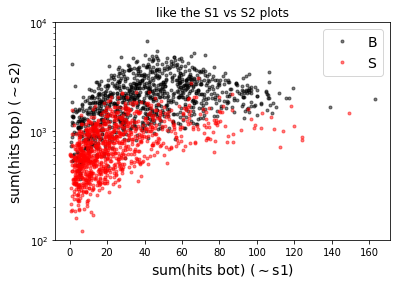

In [15]:
B_pbot = np.loadtxt(filefolder + 'ER/pbot.txt')
B_ptop = np.loadtxt(filefolder + 'ER/ptop.txt')
B_ppeakS1 = np.loadtxt(filefolder + 'ER/ppeakS1.txt')
B_ppeakS2 = np.loadtxt(filefolder + 'ER/ppeakS2.txt')

print('B_pbot.shape: ', B_pbot.shape)
print('B_ptop.shape: ', B_ptop.shape)
print('B_ppeakS1.shape :', B_ppeakS1.shape)
print('B_ppeakS2.shape: ', B_ppeakS2.shape)



S_pbot = np.loadtxt(filefolder + 'mDM' + str(mDM) + 'GeV/pbot.txt')
S_ptop = np.loadtxt(filefolder + 'mDM' + str(mDM) + 'GeV/ptop.txt')
S_ppeakS1 = np.loadtxt(filefolder + 'mDM' + str(mDM) + 'GeV/ppeakS1.txt')
S_ppeakS2 = np.loadtxt(filefolder + 'mDM' + str(mDM) + 'GeV/ppeakS2.txt')

print('S_pbot.shape: ', S_pbot.shape)
print('S_ptop.shape: ', S_ptop.shape)
print('S_ppeakS1.shape :', S_ppeakS1.shape)
print('S_ppeakS2.shape: ', S_ppeakS2.shape)


# plot to check

plt.plot(B_pbot[:1000], B_ptop[:1000], '.', color='black', alpha=0.5, label='B')
plt.plot(S_pbot[:1000], S_ptop[:1000], '.', color='red', alpha=0.5, label='S')
plt.yscale('log')
# plt.xlim([0,100])
plt.ylim([100,10000])
plt.xlabel(r'sum(hits bot) ($\sim$s1)',fontsize=14)
plt.ylabel(r'sum(hits top) ($\sim$s2)',fontsize=14)
plt.title('like the S1 vs S2 plots')
plt.legend(fontsize=14)
plt.show()

B_pbot.shape:  (5000,)
B_ptop.shape:  (5000,)
B_ppeakS1.shape : (5000, 8)
B_ppeakS2.shape:  (5000, 8)
S_pbot.shape:  (5000,)
S_ptop.shape:  (5000,)
S_ppeakS1.shape : (5000, 8)
S_ppeakS2.shape:  (5000, 8)
B_pdiffT.shape:  (5000,)
S_pdiffT.shape:  (5000,)


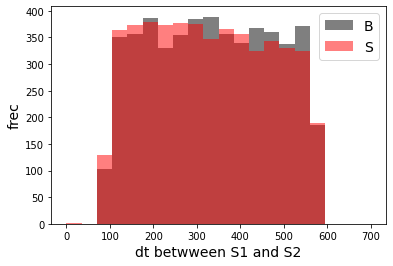

In [16]:
# to have the same number of background and signal events

B_pbot = B_pbot[:num_data]
B_ptop = B_ptop[:num_data]
B_ppeakS1 = B_ppeakS1[:num_data]
B_ppeakS2 = B_ppeakS2[:num_data]

print('B_pbot.shape: ', B_pbot.shape)
print('B_ptop.shape: ', B_ptop.shape)
print('B_ppeakS1.shape :', B_ppeakS1.shape)
print('B_ppeakS2.shape: ', B_ppeakS2.shape)


S_pbot = S_pbot[:num_data]
S_ptop = S_ptop[:num_data]
S_ppeakS1 = S_ppeakS1[:num_data]
S_ppeakS2 = S_ppeakS2[:num_data]

print('S_pbot.shape: ', S_pbot.shape)
print('S_ptop.shape: ', S_ptop.shape)
print('S_ppeakS1.shape :', S_ppeakS1.shape)
print('S_ppeakS2.shape: ', S_ppeakS2.shape)


# CONSTRUCT THE TIME DIFFERENCE BETWEEN PULSES

B_pdiffT = B_ppeakS2[:,0] - B_ppeakS1[:,0]
S_pdiffT = S_ppeakS2[:,0] - S_ppeakS1[:,0]

print('B_pdiffT.shape: ', B_pdiffT.shape)
print('S_pdiffT.shape: ', S_pdiffT.shape)


plt.hist(B_pdiffT, range=[0,700], bins=20, color='black', alpha=0.5, label='B')
plt.hist(S_pdiffT, range=[0,700], bins=20, color='red', alpha=0.5, label='S')
# plt.yscale('log')
# plt.xlim([0,100])
# plt.ylim([100,10000])
plt.xlabel('dt betwween S1 and S2',fontsize=14)
plt.ylabel('frec',fontsize=14)
plt.legend(fontsize=14)
plt.show()

##### Remove the absolute times of each pulse (we just need the time difference between pulses
other variables also can be removed if you want

In [17]:
remove_col = [0] # index = 0 is pT0

B_pbot = B_pbot
B_ptop = B_ptop
B_ppeakS1 = np.delete(B_ppeakS1, remove_col, axis=1)
B_ppeakS2 = np.delete(B_ppeakS2, remove_col, axis=1)

print('B_pbot.shape: ', B_pbot.shape)
print('B_ptop.shape: ', B_ptop.shape)
print('B_ppeakS1.shape :', B_ppeakS1.shape)
print('B_ppeakS2.shape: ', B_ppeakS2.shape)


S_pbot = S_pbot
S_ptop = S_ptop
S_ppeakS1 = np.delete(S_ppeakS1, remove_col, axis=1)
S_ppeakS2 = np.delete(S_ppeakS2, remove_col, axis=1)

print('S_pbot.shape: ', S_pbot.shape)
print('S_ptop.shape: ', S_ptop.shape)
print('S_ppeakS1.shape :', S_ppeakS1.shape)
print('S_ppeakS2.shape: ', S_ppeakS2.shape)

B_pbot.shape:  (5000,)
B_ptop.shape:  (5000,)
B_ppeakS1.shape : (5000, 7)
B_ppeakS2.shape:  (5000, 7)
S_pbot.shape:  (5000,)
S_ptop.shape:  (5000,)
S_ppeakS1.shape : (5000, 7)
S_ppeakS2.shape:  (5000, 7)


## 1. No compressed features

In [18]:
X_mon_train = np.concatenate([X_mon1_train,X_mon2_train,X_mon3_train,X_mon4_train],axis=1)
X_mon_test = np.concatenate([X_mon1_test,X_mon2_test,X_mon3_test,X_mon4_test],axis=1)
X_mon_val = np.concatenate([X_mon1_val,X_mon2_val,X_mon3_val,X_mon4_val],axis=1)



y_mon_train = y_mon1_train
y_mon_test = y_mon1_test
y_mon_val = y_mon1_val



print('')
print('X_mon_train : ', X_mon_train.shape)
print('y_mon_train : ', y_mon_train.shape)
print('X_mon_val : ', X_mon_val.shape)
print('y_mon_val : ', y_mon_val.shape)
print('X_mon_test : ', X_mon_test.shape)
print('y_mon_test : ', y_mon_test.shape)
print('')


X_mon_train :  (4999, 2724)
y_mon_train :  (4999,)
X_mon_val :  (1667, 2724)
y_mon_val :  (1667,)
X_mon_test :  (3334, 2724)
y_mon_test :  (3334,)



### CLASSIFIER

### XGBoost

/home/andres/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[0]	validation_0-logloss:0.63654	validation_1-logloss:0.64509
[1]	validation_0-logloss:0.58872	validation_1-logloss:0.60572
[2]	validation_0-logloss:0.54909	validation_1-logloss:0.57212
[3]	validation_0-logloss:0.51435	validation_1-logloss:0.54410
[4]	validation_0-logloss:0.48331	validation_1-logloss:0.51919
[5]	validation_0-logloss:0.45576	validation_1-logloss:0.49712
[6]	validation_0-logloss:0.43155	validation_1-logloss:0.47792
[7]	validation_0-logloss:0.40962	validation_1-logloss:0.46119
[8]	validation_0-logloss:0.38961	validation_1-logloss:0.44680
[9]	validation_0-logloss:0.37170	validation_1-logloss:0.43307
[10]	validation_0-logloss:0.35404	validation_1-logloss:0.42106
[11]	validation_0-logloss:0.33755	validation_1-logloss:0.40856
[12]	validation_0-logloss:0.32312	validation_1-logloss:0.39884
[13]	validation_0-logloss:0.30918	validation_1-logloss:0.38952
[14]	validation_0-logloss:0.29757	validation_1-logloss:0.38154
[15]	validation_0-logloss:0.28613	validation_1-logloss:0.37320
[1

[130]	validation_0-logloss:0.03965	validation_1-logloss:0.28351
[131]	validation_0-logloss:0.03927	validation_1-logloss:0.28383
[132]	validation_0-logloss:0.03869	validation_1-logloss:0.28348
[133]	validation_0-logloss:0.03820	validation_1-logloss:0.28319
[134]	validation_0-logloss:0.03749	validation_1-logloss:0.28338


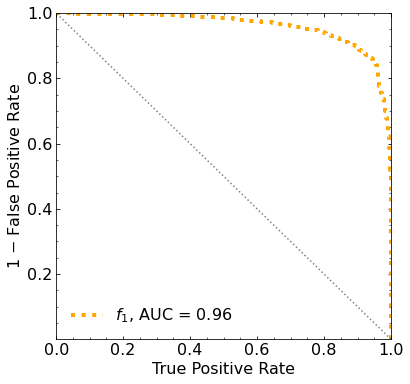

Classification score:


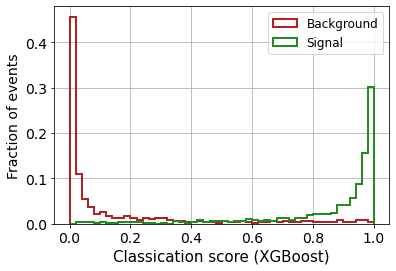


 ROC-AUC =  0.9594113446382345


In [19]:
# XGBoost with only the kinematic variables of the leptons

# CLASSIFIER
classifier = XGBClassifier(
    n_estimators=1500,
    learning_rate=0.1,
    reg_lambda=0.0,reg_alpha=0.0,
    gamma=0.0,objective='binary:logistic',
    max_depth=5,
    #eval_metric=["error", "logloss", "map"]
    eval_metric='logloss')

# FIT
classifier.fit(X_mon_train,y_mon_train,eval_set=[(X_mon_train, y_mon_train), (X_mon_val, y_mon_val)],
        early_stopping_rounds=50,#early stopping
        verbose=True)


# PREDICTIONS
y_pred_xg = classifier.predict_proba(X_mon_test).T[1]


# ROC
fpr_mon_xg, tpr_mon_xg, _ = roc_curve(y_mon_test, y_pred_xg)
roc_auc_xg = auc(fpr_mon_xg, tpr_mon_xg)


# PLOT THE ROC WITH AUC
fig = plt.figure(figsize=(6, 6))
gs = gridspec.GridSpec(1, 1) 
ax0 = plt.subplot(gs[0])
ax0.yaxis.set_ticks_position('both')
ax0.xaxis.set_ticks_position('both')
ax0.tick_params(direction="in",which="both")
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
ax0.minorticks_on()


plt.plot(tpr_mon_xg,1-fpr_mon_xg,label="$f_{1}$, AUC = %0.2f" % roc_auc_xg,color="orange",ls=":",lw=4)
plt.plot([1,0],[0,1],ls=":",color="grey")
plt.xlabel("True Positive Rate",fontsize=16)
plt.ylabel("1 $-$ False Positive Rate",fontsize=16)
plt.legend()
plt.xlim([0,1])
plt.ylim([0,1])
plt.yticks([0.2,0.4,0.6,0.8,1.])
plt.legend(frameon=False,fontsize=16)
plt.show()



# XGBoost with the kinematic variables of the leptons

########################
# CLASSIFICATION SCORE #
########################

# Outputs for validation data set

pred_XG_SM = []
pred_XG_NP = []

for i in range(len(y_mon_test)):
    if y_mon_test[i] == 0:
        pred_XG_SM.append(y_pred_xg[i])
    else:
        pred_XG_NP.append(y_pred_xg[i])
        
        
print('Classification score:')
        
weights = np.ones_like(pred_XG_SM)/float(len(pred_XG_SM))
nSM, binsSM, patchesSM = plt.hist(pred_XG_SM, 50, weights=weights, range=[0,1], histtype='step', color='firebrick', linewidth=2, label='Background')

weights = np.ones_like(pred_XG_NP)/float(len(pred_XG_NP))
nNP, binsNP, patchesNP = plt.hist(pred_XG_NP, 50, weights=weights, range=[0,1], histtype='step', color='forestgreen', linewidth=2, label='Signal')

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel("Classication score (XGBoost)",fontsize=15)
plt.ylabel("Fraction of events",fontsize=14)
plt.grid()
plt.legend(fontsize=12)

plt.show()




print('\n ROC-AUC = ', roc_auc_xg)

In [20]:
print('\n ROC-AUC = ', roc_auc_xg)


 ROC-AUC =  0.9594113446382345


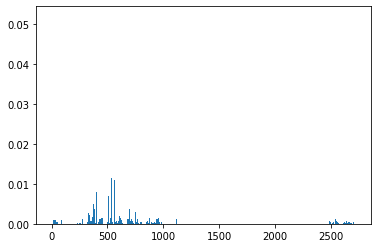

In [21]:
plt.bar(range(len(classifier.feature_importances_)), classifier.feature_importances_)
plt.show()

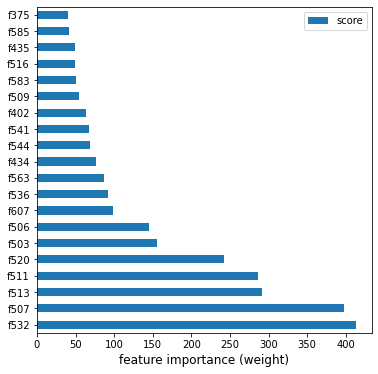

In [22]:
feature_important = classifier.get_booster().get_score(importance_type='gain')
keys = list(feature_important.keys())
#keys = ['pA_S1','pH_S1','pHT_S1','pL_S1','pL90_S1','pRMSW_S1','pHTL_S1','pA_S2','pH_S2','pHT_S2','pL_S2','pL90_S2','pRMSW_S2','pHTL_S2','pbot', 'ptop','pdiffT']
values = list(feature_important.values())

data = pd.DataFrame(data=values, index=keys, columns=["score"]).sort_values(by = "score", ascending=False)
data.nlargest(20, columns="score").plot(kind='barh', figsize = (6,6)) ## plot top 10 features
plt.xlabel('feature importance (weight)', fontsize = 12)
plt.show()

### DNN

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 32)                87200     
_________________________________________________________________
dropout (Dropout)            (None, 32)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 16)                528       
_________________________________________________________________
dropout_1 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 4)                 68        
_________________________________________________________________
dropout_2 (Dropout)          (None, 4)                 0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 5

Epoch 50/500
40/40 [==============================] - 0s 1ms/step - loss: 0.2285 - accuracy: 0.9174 - val_loss: 0.3214 - val_accuracy: 0.8794
Epoch 51/500
40/40 [==============================] - 0s 1ms/step - loss: 0.2395 - accuracy: 0.9031 - val_loss: 0.3343 - val_accuracy: 0.8800
Epoch 52/500
40/40 [==============================] - 0s 1ms/step - loss: 0.2306 - accuracy: 0.9118 - val_loss: 0.3210 - val_accuracy: 0.8818
Epoch 53/500
40/40 [==============================] - 0s 1ms/step - loss: 0.2400 - accuracy: 0.9077 - val_loss: 0.3139 - val_accuracy: 0.8782
Epoch 54/500
40/40 [==============================] - 0s 1ms/step - loss: 0.2250 - accuracy: 0.9186 - val_loss: 0.3254 - val_accuracy: 0.8794
Epoch 55/500
40/40 [==============================] - 0s 1ms/step - loss: 0.2126 - accuracy: 0.9264 - val_loss: 0.3882 - val_accuracy: 0.8794
Epoch 56/500
40/40 [==============================] - 0s 1ms/step - loss: 0.2511 - accuracy: 0.9081 - val_loss: 0.3690 - val_accuracy: 0.8884
Epoch 

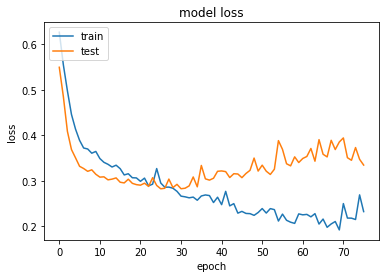

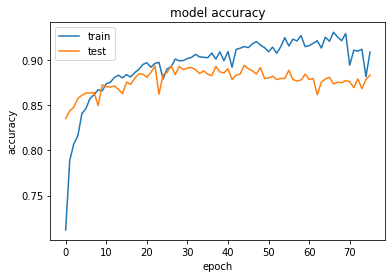

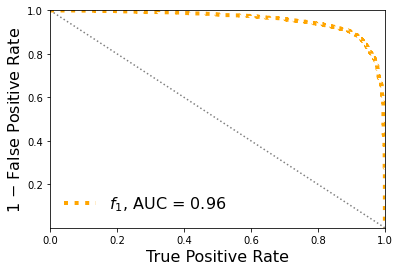

Classification score:


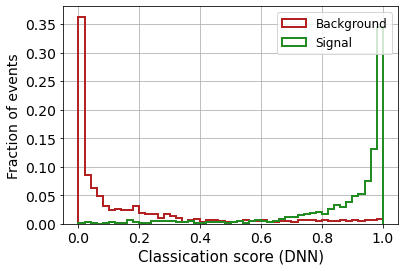


 ROC-AUC =  0.9573444064350977


In [23]:

# define the keras model
model = Sequential()
model.add(Dense(32, input_shape=(X_mon_train.shape[1],), activation='relu'))
model.add(Dropout(0.20))
# model.add(Dense(32, activation='relu'))
# model.add(Dropout(0.20))
model.add(Dense(16, activation='relu'))
model.add(Dropout(0.20))
model.add(Dense(4, activation='relu'))
model.add(Dropout(0.20))
model.add(Dense(1, activation='sigmoid'))

# Print the model summary
model.summary()

# to stop the training if validation loss does not improve after patience number of epochs
stop_training = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=50, restore_best_weights=True)

# compile the keras model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])


batch_size = 128
tot_epochs = 500


# Entrenamos el modelo
history = model.fit(X_mon_train,
                    y_mon_train,
                    batch_size=batch_size,
                    epochs=tot_epochs,
                    callbacks=[stop_training],
                    verbose=1,
                    validation_data=(X_mon_val, y_mon_val),
                    shuffle=True)


# Plot de la cost function para la train y test data
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.legend(['train', 'test'], loc='upper left')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.show()

# Plot de la accuracy function para la train y test data
plt.figure()
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()


#model.save(root_dir + 'CNN-histo-mix-v2/saved-models/' + 'conv-' + nameMIX_linear +'.h5') # Guardar el modelo.  # Predicción de la red entrenada
y_pred_dnn = model.predict(X_mon_test)

# Compute ROC curve and ROC area for each class
fpr_dnn = dict()
tpr_dnn = dict()
roc_auc_dnn = dict()
fpr_dnn, tpr_dnn, _ = roc_curve(y_mon_test, y_pred_dnn)
roc_auc_dnn = auc(fpr_dnn, tpr_dnn)


plt.figure()
plt.plot(tpr_dnn,1-fpr_dnn,label="$f_{1}$, AUC = %0.2f" % roc_auc_dnn,color="orange",ls=":",lw=4)
plt.plot([1,0],[0,1],ls=":",color="grey")
plt.xlabel("True Positive Rate",fontsize=16)
plt.ylabel("1 $-$ False Positive Rate",fontsize=16)
plt.legend()
plt.xlim([0,1])
plt.ylim([0,1])
plt.yticks([0.2,0.4,0.6,0.8,1.])
plt.legend(frameon=False,fontsize=16)
plt.show()








########################
# CLASSIFICATION SCORE #
########################

# Outputs for validation data set

pred_XG_SM = []
pred_XG_NP = []

for i in range(len(y_mon_test)):
    if y_mon_test[i] == 0:
        pred_XG_SM.append(y_pred_dnn[i,0])
    else:
        pred_XG_NP.append(y_pred_dnn[i,0])
        
        
print('Classification score:')
        
weights = np.ones_like(pred_XG_SM)/float(len(pred_XG_SM))
nSM, binsSM, patchesSM = plt.hist(pred_XG_SM, 50, weights=weights, range=[0,1], histtype='step', color='firebrick', linewidth=2, label='Background')

weights = np.ones_like(pred_XG_NP)/float(len(pred_XG_NP))
nNP, binsNP, patchesNP = plt.hist(pred_XG_NP, 50, weights=weights, range=[0,1], histtype='step', color='forestgreen', linewidth=2, label='Signal')

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel("Classication score (DNN)",fontsize=15)
plt.ylabel("Fraction of events",fontsize=14)
plt.grid()
plt.legend(fontsize=12)

plt.show()






print('\n ROC-AUC = ', roc_auc_dnn)

In [24]:
print('\n ROC-AUC = ', roc_auc_dnn)


 ROC-AUC =  0.9573444064350977


### CNN

In [25]:
# prepare the dataset
X_mon_train_cn = X_mon_train.reshape(X_mon_train.shape[0], X_mon_train.shape[1], 1)
X_mon_test_cn = X_mon_test.reshape(X_mon_test.shape[0], X_mon_test.shape[1], 1)
X_mon_val_cn = X_mon_val.reshape(X_mon_val.shape[0], X_mon_val.shape[1], 1)

Epoch 1/500
40/40 [==============================] - 4s 75ms/step - loss: 0.6710 - accuracy: 0.6781 - val_loss: 0.5838 - val_accuracy: 0.8380
Epoch 2/500
40/40 [==============================] - 3s 71ms/step - loss: 0.5651 - accuracy: 0.8468 - val_loss: 0.5364 - val_accuracy: 0.8512
Epoch 3/500
40/40 [==============================] - 3s 73ms/step - loss: 0.5102 - accuracy: 0.8702 - val_loss: 0.5249 - val_accuracy: 0.8722
Epoch 4/500
40/40 [==============================] - 3s 73ms/step - loss: 0.4996 - accuracy: 0.8644 - val_loss: 0.4981 - val_accuracy: 0.8674
Epoch 5/500
40/40 [==============================] - 3s 74ms/step - loss: 0.4807 - accuracy: 0.8614 - val_loss: 0.4879 - val_accuracy: 0.8674
Epoch 6/500
40/40 [==============================] - 3s 73ms/step - loss: 0.4686 - accuracy: 0.8750 - val_loss: 0.4898 - val_accuracy: 0.8254
Epoch 7/500
40/40 [==============================] - 3s 74ms/step - loss: 0.4579 - accuracy: 0.8600 - val_loss: 0.4825 - val_accuracy: 0.8620
Epoch 

40/40 [==============================] - 3s 72ms/step - loss: 0.2233 - accuracy: 0.9266 - val_loss: 0.3071 - val_accuracy: 0.8878
Epoch 59/500
40/40 [==============================] - 3s 71ms/step - loss: 0.2420 - accuracy: 0.9105 - val_loss: 0.3190 - val_accuracy: 0.8806
Epoch 60/500
40/40 [==============================] - 3s 71ms/step - loss: 0.2152 - accuracy: 0.9224 - val_loss: 0.3113 - val_accuracy: 0.8860
Epoch 61/500
40/40 [==============================] - 3s 73ms/step - loss: 0.2142 - accuracy: 0.9251 - val_loss: 0.3284 - val_accuracy: 0.8836
Epoch 62/500
40/40 [==============================] - 3s 71ms/step - loss: 0.2167 - accuracy: 0.9212 - val_loss: 0.3182 - val_accuracy: 0.8854
Epoch 63/500
40/40 [==============================] - 3s 71ms/step - loss: 0.2238 - accuracy: 0.9217 - val_loss: 0.3183 - val_accuracy: 0.8872
Epoch 64/500
40/40 [==============================] - 3s 72ms/step - loss: 0.2237 - accuracy: 0.9176 - val_loss: 0.3141 - val_accuracy: 0.8848
Epoch 65/500

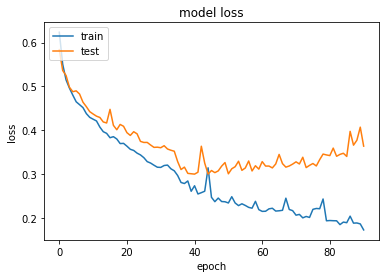

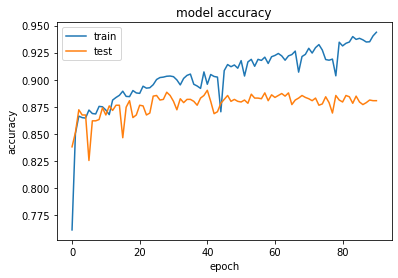

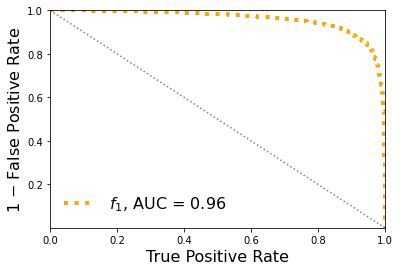

Classification score:


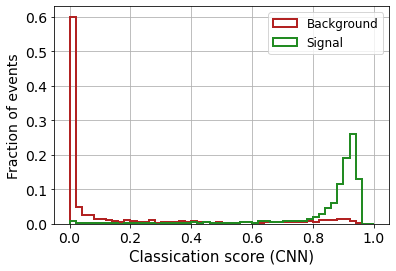


 ROC-AUC =  0.9587897334450578


In [26]:

# define the keras model
model = Sequential()
model.add(Conv1D(16, 2, input_shape=(X_mon_train.shape[1],1), activation='relu', strides = (1),kernel_regularizer=l2(0.005)))
model.add(MaxPooling1D(2, strides = (1)))
model.add(Conv1D(16, 2, input_shape=(X_mon_train.shape[1],1), activation='relu', strides = (1),kernel_regularizer=l2(0.005)))
model.add(MaxPooling1D(2, strides = (1)))
model.add(Flatten())
model.add(Dense(10, activation='relu'))
model.add(Dropout(0.20))
model.add(Dense(1, activation='sigmoid'))


# Print the model summary
#model.summary()

# to stop the training if validation loss does not improve after patience number of epochs
stop_training = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=50, restore_best_weights=True)

# compile the keras model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])


batch_size = 128
tot_epochs = 500


# Entrenamos el modelo
history = model.fit(X_mon_train_cn,
                    y_mon_train,
                    batch_size=batch_size,
                    epochs=tot_epochs,
                    callbacks=[stop_training],
                    verbose=1,
                    validation_data=(X_mon_val_cn, y_mon_val),
                    shuffle=True)


# Plot de la cost function para la train y test data
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.legend(['train', 'test'], loc='upper left')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.show()

# Plot de la accuracy function para la train y test data
plt.figure()
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()


#model.save(root_dir + 'CNN-histo-mix-v2/saved-models/' + 'conv-' + nameMIX_linear +'.h5') # Guardar el modelo.  # Predicción de la red entrenada
y_pred_cnn = model.predict(X_mon_test_cn)

# Compute ROC curve and ROC area for each class
fpr_cnn = dict()
tpr_cnn = dict()
roc_auc_cnn = dict()
fpr_cnn, tpr_cnn, _ = roc_curve(y_mon_test, y_pred_cnn)
roc_auc_cnn = auc(fpr_cnn, tpr_cnn)


plt.figure()
plt.plot(tpr_cnn,1-fpr_cnn,label="$f_{1}$, AUC = %0.2f" % roc_auc_cnn,color="orange",ls=":",lw=4)
plt.plot([1,0],[0,1],ls=":",color="grey")
plt.xlabel("True Positive Rate",fontsize=16)
plt.ylabel("1 $-$ False Positive Rate",fontsize=16)
plt.legend()
plt.xlim([0,1])
plt.ylim([0,1])
plt.yticks([0.2,0.4,0.6,0.8,1.])
plt.legend(frameon=False,fontsize=16)
plt.show()








########################
# CLASSIFICATION SCORE #
########################

# Outputs for validation data set

pred_XG_SM = []
pred_XG_NP = []

for i in range(len(y_mon_test)):
    if y_mon_test[i] == 0:
        pred_XG_SM.append(y_pred_cnn[i,0])
    else:
        pred_XG_NP.append(y_pred_cnn[i,0])
        
        
print('Classification score:')
        
weights = np.ones_like(pred_XG_SM)/float(len(pred_XG_SM))
nSM, binsSM, patchesSM = plt.hist(pred_XG_SM, 50, weights=weights, range=[0,1], histtype='step', color='firebrick', linewidth=2, label='Background')

weights = np.ones_like(pred_XG_NP)/float(len(pred_XG_NP))
nNP, binsNP, patchesNP = plt.hist(pred_XG_NP, 50, weights=weights, range=[0,1], histtype='step', color='forestgreen', linewidth=2, label='Signal')

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel("Classication score (CNN)",fontsize=15)
plt.ylabel("Fraction of events",fontsize=14)
plt.grid()
plt.legend(fontsize=12)

plt.show()






print('\n ROC-AUC = ', roc_auc_cnn)

## 2. only time diff

In [27]:
# concatenate the data

# all the background features
X_mon_B = np.reshape(B_pdiffT,(len(B_pdiffT),1))

# all the signal features
X_mon_S = np.reshape(S_pdiffT,(len(S_pdiffT),1))

print('X_mon_B.shape: ', X_mon_B.shape)
print('X_mon_S.shape: ', X_mon_S.shape)
print('')



X_mon5 = np.concatenate([X_mon_B, X_mon_S])

print('X_mon5.shape: ', X_mon5.shape)



# labels
y_mon5 = np.concatenate([np.zeros(num_data),np.ones(num_data)])




# divide into train-val and test data samples
test_ratio = 1./3
val_ratio = 0.25


X_mon5_aux, X_mon5_test, y_mon5_aux, y_mon5_test = train_test_split(X_mon5,
                                                                y_mon5,
                                                                test_size=test_ratio,
                                                                random_state=42,
                                                                #stratify = y_mon5,
                                                                shuffle=True)



X_mon5_train, X_mon5_val, y_mon5_train, y_mon5_val = train_test_split(X_mon5_aux,
                                                                  y_mon5_aux,
                                                                  test_size=val_ratio,
                                                                  random_state=42,
                                                                  #stratify = y_mon5_aux,
                                                                  shuffle=True)



print('')
print('X_mon5_train : ', X_mon5_train.shape)
print('y_mon5_train : ', y_mon5_train.shape)
print('X_mon5_val : ', X_mon5_val.shape)
print('y_mon5_val : ', y_mon5_val.shape)
print('X_mon5_test : ', X_mon5_test.shape)
print('y_mon5_test : ', y_mon5_test.shape)
print('')

X_mon_B.shape:  (5000, 1)
X_mon_S.shape:  (5000, 1)

X_mon5.shape:  (10000, 1)

X_mon5_train :  (4999, 1)
y_mon5_train :  (4999,)
X_mon5_val :  (1667, 1)
y_mon5_val :  (1667,)
X_mon5_test :  (3334, 1)
y_mon5_test :  (3334,)



In [28]:
X_mon_train = np.concatenate([X_mon1_train,X_mon2_train,X_mon3_train,X_mon4_train,X_mon5_train],axis=1)
X_mon_test = np.concatenate([X_mon1_test,X_mon2_test,X_mon3_test,X_mon4_test,X_mon5_test],axis=1)
X_mon_val = np.concatenate([X_mon1_val,X_mon2_val,X_mon3_val,X_mon4_val,X_mon5_val],axis=1)



y_mon_train = y_mon1_train
y_mon_test = y_mon1_test
y_mon_val = y_mon1_val



print('')
print('X_mon_train : ', X_mon_train.shape)
print('y_mon_train : ', y_mon_train.shape)
print('X_mon_val : ', X_mon_val.shape)
print('y_mon_val : ', y_mon_val.shape)
print('X_mon_test : ', X_mon_test.shape)
print('y_mon_test : ', y_mon_test.shape)
print('')


X_mon_train :  (4999, 2725)
y_mon_train :  (4999,)
X_mon_val :  (1667, 2725)
y_mon_val :  (1667,)
X_mon_test :  (3334, 2725)
y_mon_test :  (3334,)



### CLASSIFIER

### XGBoost

/home/andres/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[0]	validation_0-logloss:0.63648	validation_1-logloss:0.64564
[1]	validation_0-logloss:0.58857	validation_1-logloss:0.60602
[2]	validation_0-logloss:0.54815	validation_1-logloss:0.57374
[3]	validation_0-logloss:0.51294	validation_1-logloss:0.54479
[4]	validation_0-logloss:0.48134	validation_1-logloss:0.51866
[5]	validation_0-logloss:0.45398	validation_1-logloss:0.49627
[6]	validation_0-logloss:0.42939	validation_1-logloss:0.47758
[7]	validation_0-logloss:0.40750	validation_1-logloss:0.46042
[8]	validation_0-logloss:0.38734	validation_1-logloss:0.44482
[9]	validation_0-logloss:0.36825	validation_1-logloss:0.43056
[10]	validation_0-logloss:0.35067	validation_1-logloss:0.41891
[11]	validation_0-logloss:0.33503	validation_1-logloss:0.40922
[12]	validation_0-logloss:0.31950	validation_1-logloss:0.39757
[13]	validation_0-logloss:0.30629	validation_1-logloss:0.38697
[14]	validation_0-logloss:0.29395	validation_1-logloss:0.37901
[15]	validation_0-logloss:0.28200	validation_1-logloss:0.37109
[1

[130]	validation_0-logloss:0.02064	validation_1-logloss:0.22833
[131]	validation_0-logloss:0.02024	validation_1-logloss:0.22822
[132]	validation_0-logloss:0.01993	validation_1-logloss:0.22781
[133]	validation_0-logloss:0.01972	validation_1-logloss:0.22783
[134]	validation_0-logloss:0.01947	validation_1-logloss:0.22756
[135]	validation_0-logloss:0.01920	validation_1-logloss:0.22742
[136]	validation_0-logloss:0.01886	validation_1-logloss:0.22831
[137]	validation_0-logloss:0.01866	validation_1-logloss:0.22786
[138]	validation_0-logloss:0.01828	validation_1-logloss:0.22802
[139]	validation_0-logloss:0.01811	validation_1-logloss:0.22760
[140]	validation_0-logloss:0.01783	validation_1-logloss:0.22765
[141]	validation_0-logloss:0.01755	validation_1-logloss:0.22706
[142]	validation_0-logloss:0.01731	validation_1-logloss:0.22734
[143]	validation_0-logloss:0.01705	validation_1-logloss:0.22742
[144]	validation_0-logloss:0.01681	validation_1-logloss:0.22778
[145]	validation_0-logloss:0.01652	valid

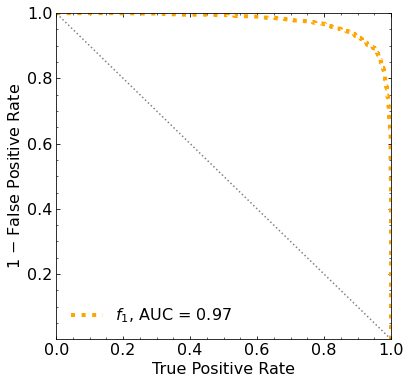

Classification score:


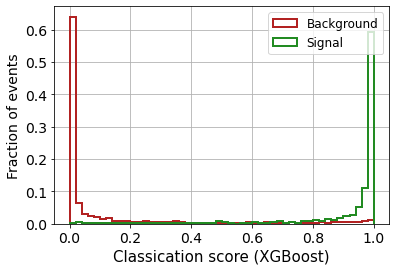


 ROC-AUC =  0.974906812311573


In [29]:
# XGBoost with only the kinematic variables of the leptons

# CLASSIFIER
classifier = XGBClassifier(
    n_estimators=1500,
    learning_rate=0.1,
    reg_lambda=0.0,reg_alpha=0.0,
    gamma=0.0,objective='binary:logistic',
    max_depth=5,
    #eval_metric=["error", "logloss", "map"]
    eval_metric='logloss')

# FIT
classifier.fit(X_mon_train,y_mon_train,eval_set=[(X_mon_train, y_mon_train), (X_mon_val, y_mon_val)],
        early_stopping_rounds=50,#early stopping
        verbose=True)


# PREDICTIONS
y_pred_xg = classifier.predict_proba(X_mon_test).T[1]


# ROC
fpr_mon_xg, tpr_mon_xg, _ = roc_curve(y_mon_test, y_pred_xg)
roc_auc_xg = auc(fpr_mon_xg, tpr_mon_xg)


# PLOT THE ROC WITH AUC
fig = plt.figure(figsize=(6, 6))
gs = gridspec.GridSpec(1, 1) 
ax0 = plt.subplot(gs[0])
ax0.yaxis.set_ticks_position('both')
ax0.xaxis.set_ticks_position('both')
ax0.tick_params(direction="in",which="both")
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
ax0.minorticks_on()


plt.plot(tpr_mon_xg,1-fpr_mon_xg,label="$f_{1}$, AUC = %0.2f" % roc_auc_xg,color="orange",ls=":",lw=4)
plt.plot([1,0],[0,1],ls=":",color="grey")
plt.xlabel("True Positive Rate",fontsize=16)
plt.ylabel("1 $-$ False Positive Rate",fontsize=16)
plt.legend()
plt.xlim([0,1])
plt.ylim([0,1])
plt.yticks([0.2,0.4,0.6,0.8,1.])
plt.legend(frameon=False,fontsize=16)
plt.show()



# XGBoost with the kinematic variables of the leptons

########################
# CLASSIFICATION SCORE #
########################

# Outputs for validation data set

pred_XG_SM = []
pred_XG_NP = []

for i in range(len(y_mon_test)):
    if y_mon_test[i] == 0:
        pred_XG_SM.append(y_pred_xg[i])
    else:
        pred_XG_NP.append(y_pred_xg[i])
        
        
print('Classification score:')
        
weights = np.ones_like(pred_XG_SM)/float(len(pred_XG_SM))
nSM, binsSM, patchesSM = plt.hist(pred_XG_SM, 50, weights=weights, range=[0,1], histtype='step', color='firebrick', linewidth=2, label='Background')

weights = np.ones_like(pred_XG_NP)/float(len(pred_XG_NP))
nNP, binsNP, patchesNP = plt.hist(pred_XG_NP, 50, weights=weights, range=[0,1], histtype='step', color='forestgreen', linewidth=2, label='Signal')

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel("Classication score (XGBoost)",fontsize=15)
plt.ylabel("Fraction of events",fontsize=14)
plt.grid()
plt.legend(fontsize=12)

plt.show()




print('\n ROC-AUC = ', roc_auc_xg)

In [30]:
print('\n ROC-AUC = ', roc_auc_xg)


 ROC-AUC =  0.974906812311573


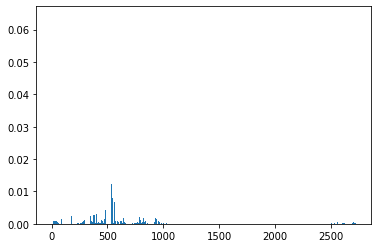

In [31]:
plt.bar(range(len(classifier.feature_importances_)), classifier.feature_importances_)
plt.show()

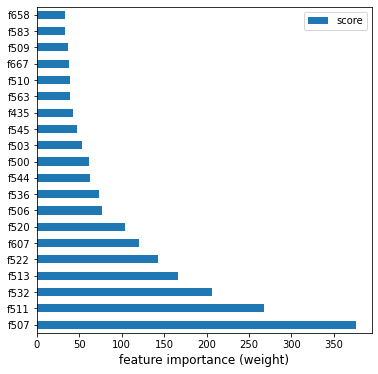


f2725: pdiffT


In [32]:
feature_important = classifier.get_booster().get_score(importance_type='gain')
keys = list(feature_important.keys())
#keys = ['pA_S1','pH_S1','pHT_S1','pL_S1','pL90_S1','pRMSW_S1','pHTL_S1','pA_S2','pH_S2','pHT_S2','pL_S2','pL90_S2','pRMSW_S2','pHTL_S2','pbot', 'ptop','pdiffT']
values = list(feature_important.values())

data = pd.DataFrame(data=values, index=keys, columns=["score"]).sort_values(by = "score", ascending=False)
data.nlargest(20, columns="score").plot(kind='barh', figsize = (6,6)) ## plot top 10 features
plt.xlabel('feature importance (weight)', fontsize = 12)
plt.show()



print('\nf'+ str(len(classifier.feature_importances_)) + ': pdiffT')

### DNN

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_6 (Dense)              (None, 32)                87232     
_________________________________________________________________
dropout_4 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_7 (Dense)              (None, 16)                528       
_________________________________________________________________
dropout_5 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense_8 (Dense)              (None, 4)                 68        
_________________________________________________________________
dropout_6 (Dropout)          (None, 4)                 0         
_________________________________________________________________
dense_9 (Dense)              (None, 1)                

Epoch 50/500
40/40 [==============================] - 0s 1ms/step - loss: 0.2432 - accuracy: 0.9223 - val_loss: 0.2227 - val_accuracy: 0.9088
Epoch 51/500
40/40 [==============================] - 0s 1ms/step - loss: 0.2507 - accuracy: 0.9180 - val_loss: 0.2283 - val_accuracy: 0.9100
Epoch 52/500
40/40 [==============================] - 0s 1ms/step - loss: 0.2649 - accuracy: 0.9035 - val_loss: 0.2493 - val_accuracy: 0.9016
Epoch 53/500
40/40 [==============================] - 0s 1ms/step - loss: 0.2563 - accuracy: 0.9111 - val_loss: 0.2465 - val_accuracy: 0.9052
Epoch 54/500
40/40 [==============================] - 0s 1ms/step - loss: 0.2734 - accuracy: 0.9065 - val_loss: 0.2508 - val_accuracy: 0.9016
Epoch 55/500
40/40 [==============================] - 0s 1ms/step - loss: 0.2502 - accuracy: 0.9167 - val_loss: 0.2000 - val_accuracy: 0.9262
Epoch 56/500
40/40 [==============================] - 0s 1ms/step - loss: 0.2458 - accuracy: 0.9201 - val_loss: 0.2207 - val_accuracy: 0.9028
Epoch 

40/40 [==============================] - 0s 1ms/step - loss: 0.1780 - accuracy: 0.9414 - val_loss: 0.2239 - val_accuracy: 0.9166
Epoch 108/500
40/40 [==============================] - 0s 1ms/step - loss: 0.2150 - accuracy: 0.9201 - val_loss: 0.2343 - val_accuracy: 0.9088
Epoch 109/500
40/40 [==============================] - 0s 1ms/step - loss: 0.2016 - accuracy: 0.9267 - val_loss: 0.2626 - val_accuracy: 0.8914
Epoch 110/500
40/40 [==============================] - 0s 1ms/step - loss: 0.2912 - accuracy: 0.8827 - val_loss: 0.2376 - val_accuracy: 0.9232
Epoch 111/500
40/40 [==============================] - 0s 1ms/step - loss: 0.2651 - accuracy: 0.9040 - val_loss: 0.2528 - val_accuracy: 0.9028
Epoch 112/500
40/40 [==============================] - 0s 1ms/step - loss: 0.2712 - accuracy: 0.8963 - val_loss: 0.2149 - val_accuracy: 0.9238
Epoch 113/500
40/40 [==============================] - 0s 1ms/step - loss: 0.2244 - accuracy: 0.9265 - val_loss: 0.2042 - val_accuracy: 0.9232
Epoch 114/500

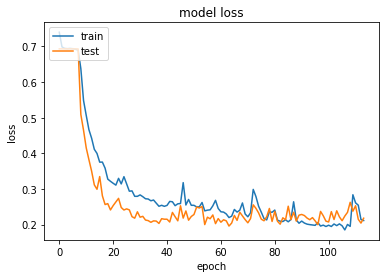

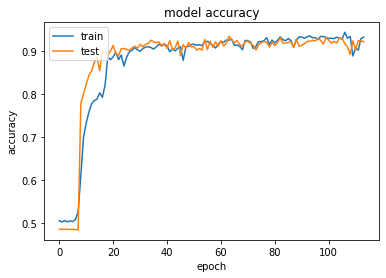

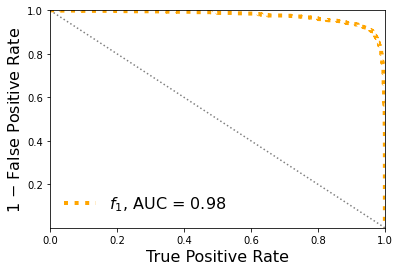

Classification score:


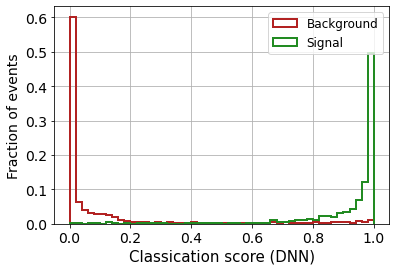


 ROC-AUC =  0.9752878056225038


In [33]:

# define the keras model
model = Sequential()
model.add(Dense(32, input_shape=(X_mon_train.shape[1],), activation='relu'))
model.add(Dropout(0.20))
# model.add(Dense(32, activation='relu'))
# model.add(Dropout(0.20))
model.add(Dense(16, activation='relu'))
model.add(Dropout(0.20))
model.add(Dense(4, activation='relu'))
model.add(Dropout(0.20))
model.add(Dense(1, activation='sigmoid'))

# Print the model summary
model.summary()

# to stop the training if validation loss does not improve after patience number of epochs
stop_training = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=50, restore_best_weights=True)

# compile the keras model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])


batch_size = 128
tot_epochs = 500


# Entrenamos el modelo
history = model.fit(X_mon_train,
                    y_mon_train,
                    batch_size=batch_size,
                    epochs=tot_epochs,
                    callbacks=[stop_training],
                    verbose=1,
                    validation_data=(X_mon_val, y_mon_val),
                    shuffle=True)


# Plot de la cost function para la train y test data
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.legend(['train', 'test'], loc='upper left')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.show()

# Plot de la accuracy function para la train y test data
plt.figure()
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()


#model.save(root_dir + 'CNN-histo-mix-v2/saved-models/' + 'conv-' + nameMIX_linear +'.h5') # Guardar el modelo.  # Predicción de la red entrenada
y_pred_dnn = model.predict(X_mon_test)

# Compute ROC curve and ROC area for each class
fpr_dnn = dict()
tpr_dnn = dict()
roc_auc_dnn = dict()
fpr_dnn, tpr_dnn, _ = roc_curve(y_mon_test, y_pred_dnn)
roc_auc_dnn = auc(fpr_dnn, tpr_dnn)


plt.figure()
plt.plot(tpr_dnn,1-fpr_dnn,label="$f_{1}$, AUC = %0.2f" % roc_auc_dnn,color="orange",ls=":",lw=4)
plt.plot([1,0],[0,1],ls=":",color="grey")
plt.xlabel("True Positive Rate",fontsize=16)
plt.ylabel("1 $-$ False Positive Rate",fontsize=16)
plt.legend()
plt.xlim([0,1])
plt.ylim([0,1])
plt.yticks([0.2,0.4,0.6,0.8,1.])
plt.legend(frameon=False,fontsize=16)
plt.show()








########################
# CLASSIFICATION SCORE #
########################

# Outputs for validation data set

pred_XG_SM = []
pred_XG_NP = []

for i in range(len(y_mon_test)):
    if y_mon_test[i] == 0:
        pred_XG_SM.append(y_pred_dnn[i,0])
    else:
        pred_XG_NP.append(y_pred_dnn[i,0])
        
        
print('Classification score:')
        
weights = np.ones_like(pred_XG_SM)/float(len(pred_XG_SM))
nSM, binsSM, patchesSM = plt.hist(pred_XG_SM, 50, weights=weights, range=[0,1], histtype='step', color='firebrick', linewidth=2, label='Background')

weights = np.ones_like(pred_XG_NP)/float(len(pred_XG_NP))
nNP, binsNP, patchesNP = plt.hist(pred_XG_NP, 50, weights=weights, range=[0,1], histtype='step', color='forestgreen', linewidth=2, label='Signal')

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel("Classication score (DNN)",fontsize=15)
plt.ylabel("Fraction of events",fontsize=14)
plt.grid()
plt.legend(fontsize=12)

plt.show()






print('\n ROC-AUC = ', roc_auc_dnn)

In [34]:
print('\n ROC-AUC = ', roc_auc_dnn)


 ROC-AUC =  0.9752878056225038


### CNN

In [35]:
# prepare the dataset
X_mon_train_cn = X_mon_train.reshape(X_mon_train.shape[0], X_mon_train.shape[1], 1)
X_mon_test_cn = X_mon_test.reshape(X_mon_test.shape[0], X_mon_test.shape[1], 1)
X_mon_val_cn = X_mon_val.reshape(X_mon_val.shape[0], X_mon_val.shape[1], 1)

Epoch 1/500
40/40 [==============================] - 4s 77ms/step - loss: 0.6931 - accuracy: 0.6482 - val_loss: 0.4554 - val_accuracy: 0.8290
Epoch 2/500
40/40 [==============================] - 3s 74ms/step - loss: 0.4867 - accuracy: 0.7784 - val_loss: 0.3790 - val_accuracy: 0.8656
Epoch 3/500
40/40 [==============================] - 3s 71ms/step - loss: 0.4103 - accuracy: 0.8261 - val_loss: 0.3349 - val_accuracy: 0.8794
Epoch 4/500
40/40 [==============================] - 3s 71ms/step - loss: 0.3693 - accuracy: 0.8654 - val_loss: 0.2923 - val_accuracy: 0.9130
Epoch 5/500
40/40 [==============================] - 3s 72ms/step - loss: 0.3543 - accuracy: 0.8785 - val_loss: 0.3153 - val_accuracy: 0.8824
Epoch 6/500
40/40 [==============================] - 3s 73ms/step - loss: 0.3423 - accuracy: 0.8835 - val_loss: 0.2694 - val_accuracy: 0.9106
Epoch 7/500
40/40 [==============================] - 3s 73ms/step - loss: 0.3296 - accuracy: 0.8787 - val_loss: 0.2669 - val_accuracy: 0.9178
Epoch 

40/40 [==============================] - 3s 74ms/step - loss: 0.2096 - accuracy: 0.9239 - val_loss: 0.2950 - val_accuracy: 0.9064
Epoch 59/500
40/40 [==============================] - 3s 74ms/step - loss: 0.2200 - accuracy: 0.9221 - val_loss: 0.2479 - val_accuracy: 0.9202
Epoch 60/500
40/40 [==============================] - 3s 73ms/step - loss: 0.1963 - accuracy: 0.9286 - val_loss: 0.2543 - val_accuracy: 0.9142
Epoch 61/500
40/40 [==============================] - 3s 74ms/step - loss: 0.2146 - accuracy: 0.9231 - val_loss: 0.2372 - val_accuracy: 0.9190
Epoch 62/500
40/40 [==============================] - 3s 74ms/step - loss: 0.1965 - accuracy: 0.9317 - val_loss: 0.2491 - val_accuracy: 0.8986
Epoch 63/500
40/40 [==============================] - 3s 74ms/step - loss: 0.2210 - accuracy: 0.9209 - val_loss: 0.2504 - val_accuracy: 0.9034
Epoch 64/500
40/40 [==============================] - 3s 73ms/step - loss: 0.1945 - accuracy: 0.9283 - val_loss: 0.2523 - val_accuracy: 0.9178
Epoch 65/500

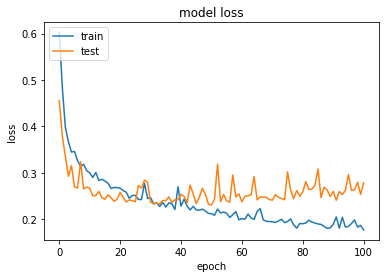

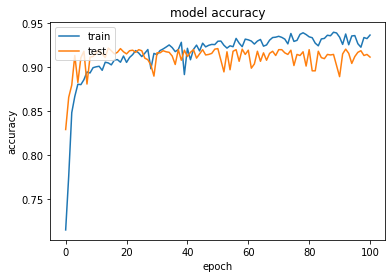

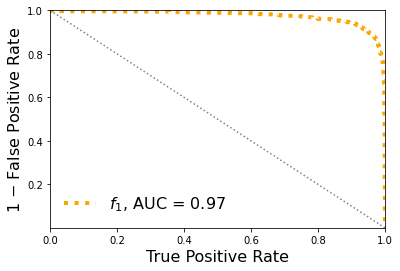

Classification score:


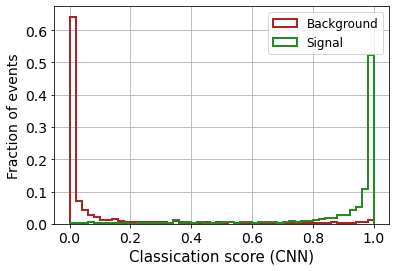


 ROC-AUC =  0.9743636673836612


In [36]:

# define the keras model
model = Sequential()
model.add(Conv1D(16, 2, input_shape=(X_mon_train.shape[1],1), activation='relu', strides = (1),kernel_regularizer=l2(0.005)))
model.add(MaxPooling1D(2, strides = (1)))
model.add(Conv1D(16, 2, input_shape=(X_mon_train.shape[1],1), activation='relu', strides = (1),kernel_regularizer=l2(0.005)))
model.add(MaxPooling1D(2, strides = (1)))
model.add(Flatten())
model.add(Dense(10, activation='relu'))
model.add(Dropout(0.20))
model.add(Dense(1, activation='sigmoid'))


# Print the model summary
#model.summary()

# to stop the training if validation loss does not improve after patience number of epochs
stop_training = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=50, restore_best_weights=True)

# compile the keras model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])


batch_size = 128
tot_epochs = 500


# Entrenamos el modelo
history = model.fit(X_mon_train_cn,
                    y_mon_train,
                    batch_size=batch_size,
                    epochs=tot_epochs,
                    callbacks=[stop_training],
                    verbose=1,
                    validation_data=(X_mon_val_cn, y_mon_val),
                    shuffle=True)


# Plot de la cost function para la train y test data
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.legend(['train', 'test'], loc='upper left')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.show()

# Plot de la accuracy function para la train y test data
plt.figure()
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()


#model.save(root_dir + 'CNN-histo-mix-v2/saved-models/' + 'conv-' + nameMIX_linear +'.h5') # Guardar el modelo.  # Predicción de la red entrenada
y_pred_cnn = model.predict(X_mon_test_cn)

# Compute ROC curve and ROC area for each class
fpr_cnn = dict()
tpr_cnn = dict()
roc_auc_cnn = dict()
fpr_cnn, tpr_cnn, _ = roc_curve(y_mon_test, y_pred_cnn)
roc_auc_cnn = auc(fpr_cnn, tpr_cnn)


plt.figure()
plt.plot(tpr_cnn,1-fpr_cnn,label="$f_{1}$, AUC = %0.2f" % roc_auc_cnn,color="orange",ls=":",lw=4)
plt.plot([1,0],[0,1],ls=":",color="grey")
plt.xlabel("True Positive Rate",fontsize=16)
plt.ylabel("1 $-$ False Positive Rate",fontsize=16)
plt.legend()
plt.xlim([0,1])
plt.ylim([0,1])
plt.yticks([0.2,0.4,0.6,0.8,1.])
plt.legend(frameon=False,fontsize=16)
plt.show()








########################
# CLASSIFICATION SCORE #
########################

# Outputs for validation data set

pred_XG_SM = []
pred_XG_NP = []

for i in range(len(y_mon_test)):
    if y_mon_test[i] == 0:
        pred_XG_SM.append(y_pred_cnn[i,0])
    else:
        pred_XG_NP.append(y_pred_cnn[i,0])
        
        
print('Classification score:')
        
weights = np.ones_like(pred_XG_SM)/float(len(pred_XG_SM))
nSM, binsSM, patchesSM = plt.hist(pred_XG_SM, 50, weights=weights, range=[0,1], histtype='step', color='firebrick', linewidth=2, label='Background')

weights = np.ones_like(pred_XG_NP)/float(len(pred_XG_NP))
nNP, binsNP, patchesNP = plt.hist(pred_XG_NP, 50, weights=weights, range=[0,1], histtype='step', color='forestgreen', linewidth=2, label='Signal')

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel("Classication score (CNN)",fontsize=15)
plt.ylabel("Fraction of events",fontsize=14)
plt.grid()
plt.legend(fontsize=12)

plt.show()






print('\n ROC-AUC = ', roc_auc_cnn)

## 3. All compressed features

In [37]:
# concatenate the data

# all the background features
X_mon_B = np.concatenate([B_ppeakS1, B_ppeakS2, np.reshape(B_pbot,(len(B_pbot),1)), np.reshape(B_ptop,(len(B_ptop),1)), np.reshape(B_pdiffT,(len(B_pdiffT),1)) ],axis=1)

# all the signal features
X_mon_S = np.concatenate([S_ppeakS1, S_ppeakS2, np.reshape(S_pbot,(len(S_pbot),1)), np.reshape(S_ptop,(len(S_ptop),1)), np.reshape(S_pdiffT,(len(S_pdiffT),1)) ],axis=1)

print('X_mon_B.shape: ', X_mon_B.shape)
print('X_mon_S.shape: ', X_mon_S.shape)
print('')

del B_ppeakS1
del B_ppeakS2
del B_pbot
del B_ptop

del S_ppeakS1
del S_ppeakS2
del S_pbot
del S_ptop


X_mon5 = np.concatenate([X_mon_B, X_mon_S])

print('X_mon5.shape: ', X_mon5.shape)
del X_mon_B
del X_mon_S


# labels
y_mon5 = np.concatenate([np.zeros(num_data),np.ones(num_data)])




# divide into train-val and test data samples
test_ratio = 1./3
val_ratio = 0.25


X_mon5_aux, X_mon5_test, y_mon5_aux, y_mon5_test = train_test_split(X_mon5,
                                                                y_mon5,
                                                                test_size=test_ratio,
                                                                random_state=42,
                                                                #stratify = y_mon5,
                                                                shuffle=True)

del X_mon5
del y_mon5

X_mon5_train, X_mon5_val, y_mon5_train, y_mon5_val = train_test_split(X_mon5_aux,
                                                                  y_mon5_aux,
                                                                  test_size=val_ratio,
                                                                  random_state=42,
                                                                  #stratify = y_mon5_aux,
                                                                  shuffle=True)

del X_mon5_aux
del y_mon5_aux

print('')
print('X_mon5_train : ', X_mon5_train.shape)
print('y_mon5_train : ', y_mon5_train.shape)
print('X_mon5_val : ', X_mon5_val.shape)
print('y_mon5_val : ', y_mon5_val.shape)
print('X_mon5_test : ', X_mon5_test.shape)
print('y_mon5_test : ', y_mon5_test.shape)
print('')

X_mon_B.shape:  (5000, 17)
X_mon_S.shape:  (5000, 17)

X_mon5.shape:  (10000, 17)

X_mon5_train :  (4999, 17)
y_mon5_train :  (4999,)
X_mon5_val :  (1667, 17)
y_mon5_val :  (1667,)
X_mon5_test :  (3334, 17)
y_mon5_test :  (3334,)



##### Concatenate into one single big dataset

In [38]:
X_mon_train = np.concatenate([X_mon1_train,X_mon2_train,X_mon3_train,X_mon4_train,X_mon5_train],axis=1)
X_mon_test = np.concatenate([X_mon1_test,X_mon2_test,X_mon3_test,X_mon4_test,X_mon5_test],axis=1)
X_mon_val = np.concatenate([X_mon1_val,X_mon2_val,X_mon3_val,X_mon4_val,X_mon5_val],axis=1)

del X_mon1_train
del X_mon2_train
del X_mon3_train
del X_mon4_train
del X_mon5_train

del X_mon1_test
del X_mon2_test
del X_mon3_test
del X_mon4_test
del X_mon5_test

del X_mon1_val
del X_mon2_val
del X_mon3_val
del X_mon4_val
del X_mon5_val



y_mon_train = y_mon1_train
y_mon_test = y_mon1_test
y_mon_val = y_mon1_val

del y_mon1_train
del y_mon2_train
del y_mon3_train
del y_mon4_train
del y_mon5_train

del y_mon1_test
del y_mon2_test
del y_mon3_test
del y_mon4_test
del y_mon5_test

del y_mon1_val
del y_mon2_val
del y_mon3_val
del y_mon4_val
del y_mon5_val


In [39]:
print('')
print('X_mon_train : ', X_mon_train.shape)
print('y_mon_train : ', y_mon_train.shape)
print('X_mon_val : ', X_mon_val.shape)
print('y_mon_val : ', y_mon_val.shape)
print('X_mon_test : ', X_mon_test.shape)
print('y_mon_test : ', y_mon_test.shape)
print('')


X_mon_train :  (4999, 2741)
y_mon_train :  (4999,)
X_mon_val :  (1667, 2741)
y_mon_val :  (1667,)
X_mon_test :  (3334, 2741)
y_mon_test :  (3334,)



### CLASSIFIER

### XGBoost

/home/andres/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[0]	validation_0-logloss:0.62663	validation_1-logloss:0.63412
[1]	validation_0-logloss:0.57079	validation_1-logloss:0.58374
[2]	validation_0-logloss:0.52339	validation_1-logloss:0.54125
[3]	validation_0-logloss:0.48165	validation_1-logloss:0.50352
[4]	validation_0-logloss:0.44628	validation_1-logloss:0.47347
[5]	validation_0-logloss:0.41458	validation_1-logloss:0.44384
[6]	validation_0-logloss:0.38732	validation_1-logloss:0.42067
[7]	validation_0-logloss:0.36301	validation_1-logloss:0.40146
[8]	validation_0-logloss:0.34183	validation_1-logloss:0.38392
[9]	validation_0-logloss:0.32184	validation_1-logloss:0.36766
[10]	validation_0-logloss:0.30466	validation_1-logloss:0.35347
[11]	validation_0-logloss:0.28799	validation_1-logloss:0.33944
[12]	validation_0-logloss:0.27247	validation_1-logloss:0.32615
[13]	validation_0-logloss:0.25906	validation_1-logloss:0.31627
[14]	validation_0-logloss:0.24747	validation_1-logloss:0.30783
[15]	validation_0-logloss:0.23729	validation_1-logloss:0.30073
[1

[130]	validation_0-logloss:0.02190	validation_1-logloss:0.20732
[131]	validation_0-logloss:0.02151	validation_1-logloss:0.20770
[132]	validation_0-logloss:0.02118	validation_1-logloss:0.20775
[133]	validation_0-logloss:0.02102	validation_1-logloss:0.20780


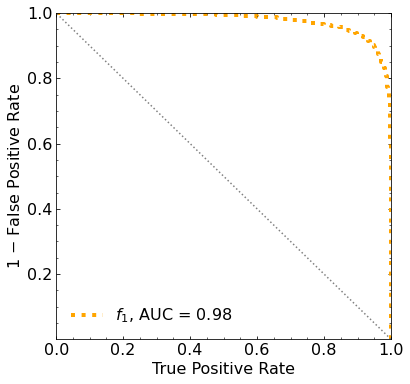

Classification score:


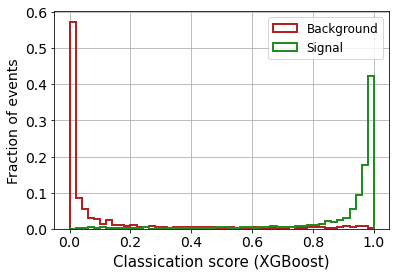


 ROC-AUC =  0.9770918098496039


In [40]:
# XGBoost with only the kinematic variables of the leptons

# CLASSIFIER
classifier = XGBClassifier(
    n_estimators=1500,
    learning_rate=0.1,
    reg_lambda=0.0,reg_alpha=0.0,
    gamma=0.0,objective='binary:logistic',
    max_depth=5,
    #eval_metric=["error", "logloss", "map"]
    eval_metric='logloss')

# FIT
classifier.fit(X_mon_train,y_mon_train,eval_set=[(X_mon_train, y_mon_train), (X_mon_val, y_mon_val)],
        early_stopping_rounds=50,#early stopping
        verbose=True)


# PREDICTIONS
y_pred_xg = classifier.predict_proba(X_mon_test).T[1]


# ROC
fpr_mon_xg, tpr_mon_xg, _ = roc_curve(y_mon_test, y_pred_xg)
roc_auc_xg = auc(fpr_mon_xg, tpr_mon_xg)


# PLOT THE ROC WITH AUC
fig = plt.figure(figsize=(6, 6))
gs = gridspec.GridSpec(1, 1) 
ax0 = plt.subplot(gs[0])
ax0.yaxis.set_ticks_position('both')
ax0.xaxis.set_ticks_position('both')
ax0.tick_params(direction="in",which="both")
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
ax0.minorticks_on()


plt.plot(tpr_mon_xg,1-fpr_mon_xg,label="$f_{1}$, AUC = %0.2f" % roc_auc_xg,color="orange",ls=":",lw=4)
plt.plot([1,0],[0,1],ls=":",color="grey")
plt.xlabel("True Positive Rate",fontsize=16)
plt.ylabel("1 $-$ False Positive Rate",fontsize=16)
plt.legend()
plt.xlim([0,1])
plt.ylim([0,1])
plt.yticks([0.2,0.4,0.6,0.8,1.])
plt.legend(frameon=False,fontsize=16)
plt.show()



# XGBoost with the kinematic variables of the leptons

########################
# CLASSIFICATION SCORE #
########################

# Outputs for validation data set

pred_XG_SM = []
pred_XG_NP = []

for i in range(len(y_mon_test)):
    if y_mon_test[i] == 0:
        pred_XG_SM.append(y_pred_xg[i])
    else:
        pred_XG_NP.append(y_pred_xg[i])
        
        
print('Classification score:')
        
weights = np.ones_like(pred_XG_SM)/float(len(pred_XG_SM))
nSM, binsSM, patchesSM = plt.hist(pred_XG_SM, 50, weights=weights, range=[0,1], histtype='step', color='firebrick', linewidth=2, label='Background')

weights = np.ones_like(pred_XG_NP)/float(len(pred_XG_NP))
nNP, binsNP, patchesNP = plt.hist(pred_XG_NP, 50, weights=weights, range=[0,1], histtype='step', color='forestgreen', linewidth=2, label='Signal')

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel("Classication score (XGBoost)",fontsize=15)
plt.ylabel("Fraction of events",fontsize=14)
plt.grid()
plt.legend(fontsize=12)

plt.show()




print('\n ROC-AUC = ', roc_auc_xg)

In [41]:
print('\n ROC-AUC = ', roc_auc_xg)


 ROC-AUC =  0.9770918098496039


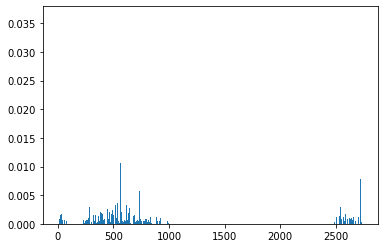

In [42]:
plt.bar(range(len(classifier.feature_importances_)), classifier.feature_importances_)
plt.show()

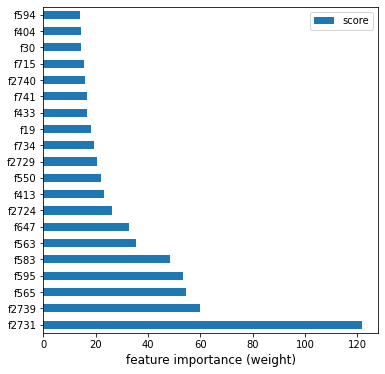


peakS1:   178 features  --> f0 to f177
peakS2:    2298 features  --> f178 to f2475
hits bot:   121 features  --> f2476 to f2596
hits top:   127 features  --> f2597 to f2723
resumed:     17 features  --> f2724 to f2740

 pA_S1 
 pH_S1 
 pHT_S1 
 pL_S1 
 pL90_S1 
 pRMSW_S1 
 pHTL_S1 
 pA_S2 
 pH_S2 
 pHT_S2 
 pL_S2 
 pL90_S2 
 pRMSW_S2 
 pHTL_S2 
 pbot 
 ptop 
 pdiffT


In [49]:
feature_important = classifier.get_booster().get_score(importance_type='gain')
keys = list(feature_important.keys())
#keys = ['pA_S1','pH_S1','pHT_S1','pL_S1','pL90_S1','pRMSW_S1','pHTL_S1','pA_S2','pH_S2','pHT_S2','pL_S2','pL90_S2','pRMSW_S2','pHTL_S2','pbot', 'ptop','pdiffT']
values = list(feature_important.values())

data = pd.DataFrame(data=values, index=keys, columns=["score"]).sort_values(by = "score", ascending=False)
data.nlargest(20, columns="score").plot(kind='barh', figsize = (6,6)) ## plot top 10 features
plt.xlabel('feature importance (weight)', fontsize = 12)
plt.show()

print('\npeakS1:   ' + str(max_pS1_both) + ' features  --> f0 to f' + str(max_pS1_both-1))
print('peakS2:    ' + str(max_pS2_both) + ' features  --> f' + str(max_pS1_both) + ' to f' + str(max_pS1_both+max_pS2_both-1))
print('hits bot:   121 features  --> f' + str(max_pS1_both+max_pS2_both) + ' to f' + str(max_pS1_both+max_pS2_both+120))
print('hits top:   127 features  --> f' + str(max_pS1_both+max_pS2_both+121) + ' to f' + str(max_pS1_both+max_pS2_both+121+126))
print('resumed:     17 features  --> f' + str(max_pS1_both+max_pS2_both+121+127) + ' to f' + str(max_pS1_both+max_pS2_both+121+127+16))

print('\n pA_S1',
      '\n pH_S1',
      '\n pHT_S1',
      '\n pL_S1',
      '\n pL90_S1',
      '\n pRMSW_S1',
      '\n pHTL_S1',
      '\n pA_S2',
      '\n pH_S2',
      '\n pHT_S2',
      '\n pL_S2',
      '\n pL90_S2',
      '\n pRMSW_S2',
      '\n pHTL_S2',
      '\n pbot', 
      '\n ptop',
      '\n pdiffT')

### DNN

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_12 (Dense)             (None, 32)                87744     
_________________________________________________________________
dropout_8 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_13 (Dense)             (None, 16)                528       
_________________________________________________________________
dropout_9 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense_14 (Dense)             (None, 4)                 68        
_________________________________________________________________
dropout_10 (Dropout)         (None, 4)                 0         
_________________________________________________________________
dense_15 (Dense)             (None, 1)                

Epoch 50/500
40/40 [==============================] - 0s 1ms/step - loss: 0.3709 - accuracy: 0.8118 - val_loss: 0.2636 - val_accuracy: 0.8980
Epoch 51/500
40/40 [==============================] - 0s 2ms/step - loss: 0.3628 - accuracy: 0.8293 - val_loss: 0.2731 - val_accuracy: 0.8860
Epoch 52/500
40/40 [==============================] - 0s 1ms/step - loss: 0.3828 - accuracy: 0.8034 - val_loss: 0.2266 - val_accuracy: 0.9070
Epoch 53/500
40/40 [==============================] - 0s 1ms/step - loss: 0.3566 - accuracy: 0.8094 - val_loss: 0.2600 - val_accuracy: 0.8824
Epoch 54/500
40/40 [==============================] - 0s 1ms/step - loss: 0.3683 - accuracy: 0.8001 - val_loss: 0.2379 - val_accuracy: 0.8992
Epoch 55/500
40/40 [==============================] - 0s 1ms/step - loss: 0.3427 - accuracy: 0.8242 - val_loss: 0.2712 - val_accuracy: 0.8872
Epoch 56/500
40/40 [==============================] - 0s 1ms/step - loss: 0.4164 - accuracy: 0.8065 - val_loss: 0.2800 - val_accuracy: 0.9028
Epoch 

40/40 [==============================] - 0s 1ms/step - loss: 0.3425 - accuracy: 0.8493 - val_loss: 0.2531 - val_accuracy: 0.8896
Epoch 108/500
40/40 [==============================] - 0s 1ms/step - loss: 0.3272 - accuracy: 0.8585 - val_loss: 0.2271 - val_accuracy: 0.9040
Epoch 109/500
40/40 [==============================] - 0s 1ms/step - loss: 0.3278 - accuracy: 0.8714 - val_loss: 0.2276 - val_accuracy: 0.9040
Epoch 110/500
40/40 [==============================] - 0s 1ms/step - loss: 0.3210 - accuracy: 0.8637 - val_loss: 0.2270 - val_accuracy: 0.9040
Epoch 111/500
40/40 [==============================] - 0s 1ms/step - loss: 0.2977 - accuracy: 0.8808 - val_loss: 0.2327 - val_accuracy: 0.8980
Epoch 112/500
40/40 [==============================] - 0s 1ms/step - loss: 0.3266 - accuracy: 0.8600 - val_loss: 0.2514 - val_accuracy: 0.8770
Epoch 113/500
40/40 [==============================] - 0s 1ms/step - loss: 0.3378 - accuracy: 0.8567 - val_loss: 0.2334 - val_accuracy: 0.8962
Epoch 114/500

40/40 [==============================] - 0s 1ms/step - loss: 0.3625 - accuracy: 0.8786 - val_loss: 0.2849 - val_accuracy: 0.8842
Epoch 165/500
40/40 [==============================] - 0s 1ms/step - loss: 0.3673 - accuracy: 0.8680 - val_loss: 0.2588 - val_accuracy: 0.9088
Epoch 166/500
40/40 [==============================] - 0s 1ms/step - loss: 0.3541 - accuracy: 0.8774 - val_loss: 0.2645 - val_accuracy: 0.8998
Epoch 167/500
40/40 [==============================] - 0s 1ms/step - loss: 0.3600 - accuracy: 0.8727 - val_loss: 0.2711 - val_accuracy: 0.8950
Epoch 168/500
40/40 [==============================] - 0s 1ms/step - loss: 0.3368 - accuracy: 0.8833 - val_loss: 0.2564 - val_accuracy: 0.9100
Epoch 169/500
40/40 [==============================] - 0s 1ms/step - loss: 0.3228 - accuracy: 0.8858 - val_loss: 0.3087 - val_accuracy: 0.8914
Restoring model weights from the end of the best epoch.
Epoch 00169: early stopping


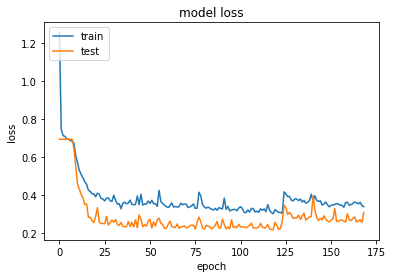

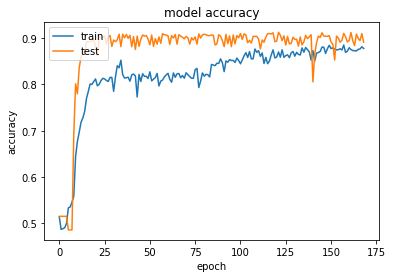

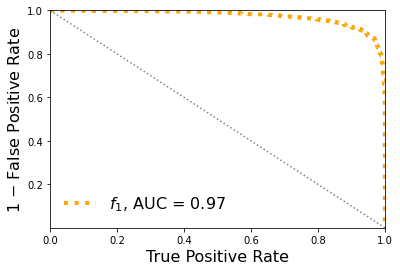

Classification score:


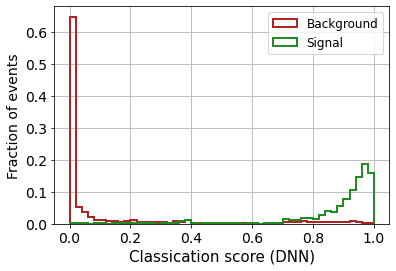


 ROC-AUC =  0.9725013533631074


In [50]:

# define the keras model
model = Sequential()
model.add(Dense(32, input_shape=(X_mon_train.shape[1],), activation='relu'))
model.add(Dropout(0.20))
# model.add(Dense(32, activation='relu'))
# model.add(Dropout(0.20))
model.add(Dense(16, activation='relu'))
model.add(Dropout(0.20))
model.add(Dense(4, activation='relu'))
model.add(Dropout(0.20))
model.add(Dense(1, activation='sigmoid'))

# Print the model summary
model.summary()

# to stop the training if validation loss does not improve after patience number of epochs
stop_training = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=50, restore_best_weights=True)

# compile the keras model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])


batch_size = 128
tot_epochs = 500


# Entrenamos el modelo
history = model.fit(X_mon_train,
                    y_mon_train,
                    batch_size=batch_size,
                    epochs=tot_epochs,
                    callbacks=[stop_training],
                    verbose=1,
                    validation_data=(X_mon_val, y_mon_val),
                    shuffle=True)


# Plot de la cost function para la train y test data
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.legend(['train', 'test'], loc='upper left')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.show()

# Plot de la accuracy function para la train y test data
plt.figure()
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()


#model.save(root_dir + 'CNN-histo-mix-v2/saved-models/' + 'conv-' + nameMIX_linear +'.h5') # Guardar el modelo.  # Predicción de la red entrenada
y_pred_dnn = model.predict(X_mon_test)

# Compute ROC curve and ROC area for each class
fpr_dnn = dict()
tpr_dnn = dict()
roc_auc_dnn = dict()
fpr_dnn, tpr_dnn, _ = roc_curve(y_mon_test, y_pred_dnn)
roc_auc_dnn = auc(fpr_dnn, tpr_dnn)


plt.figure()
plt.plot(tpr_dnn,1-fpr_dnn,label="$f_{1}$, AUC = %0.2f" % roc_auc_dnn,color="orange",ls=":",lw=4)
plt.plot([1,0],[0,1],ls=":",color="grey")
plt.xlabel("True Positive Rate",fontsize=16)
plt.ylabel("1 $-$ False Positive Rate",fontsize=16)
plt.legend()
plt.xlim([0,1])
plt.ylim([0,1])
plt.yticks([0.2,0.4,0.6,0.8,1.])
plt.legend(frameon=False,fontsize=16)
plt.show()








########################
# CLASSIFICATION SCORE #
########################

# Outputs for validation data set

pred_XG_SM = []
pred_XG_NP = []

for i in range(len(y_mon_test)):
    if y_mon_test[i] == 0:
        pred_XG_SM.append(y_pred_dnn[i,0])
    else:
        pred_XG_NP.append(y_pred_dnn[i,0])
        
        
print('Classification score:')
        
weights = np.ones_like(pred_XG_SM)/float(len(pred_XG_SM))
nSM, binsSM, patchesSM = plt.hist(pred_XG_SM, 50, weights=weights, range=[0,1], histtype='step', color='firebrick', linewidth=2, label='Background')

weights = np.ones_like(pred_XG_NP)/float(len(pred_XG_NP))
nNP, binsNP, patchesNP = plt.hist(pred_XG_NP, 50, weights=weights, range=[0,1], histtype='step', color='forestgreen', linewidth=2, label='Signal')

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel("Classication score (DNN)",fontsize=15)
plt.ylabel("Fraction of events",fontsize=14)
plt.grid()
plt.legend(fontsize=12)

plt.show()






print('\n ROC-AUC = ', roc_auc_dnn)

In [51]:
print('\n ROC-AUC = ', roc_auc_dnn)


 ROC-AUC =  0.9725013533631074


### CNN

In [52]:
# prepare the dataset
X_mon_train_cn = X_mon_train.reshape(X_mon_train.shape[0], X_mon_train.shape[1], 1)
X_mon_test_cn = X_mon_test.reshape(X_mon_test.shape[0], X_mon_test.shape[1], 1)
X_mon_val_cn = X_mon_val.reshape(X_mon_val.shape[0], X_mon_val.shape[1], 1)

Epoch 1/500
40/40 [==============================] - 4s 77ms/step - loss: 3.7853 - accuracy: 0.5711 - val_loss: 0.6115 - val_accuracy: 0.8152
Epoch 2/500
40/40 [==============================] - 3s 73ms/step - loss: 0.6360 - accuracy: 0.7440 - val_loss: 0.5871 - val_accuracy: 0.8290
Epoch 3/500
40/40 [==============================] - 3s 72ms/step - loss: 0.6141 - accuracy: 0.7684 - val_loss: 0.5996 - val_accuracy: 0.8254
Epoch 4/500
40/40 [==============================] - 3s 75ms/step - loss: 0.6051 - accuracy: 0.7613 - val_loss: 0.5497 - val_accuracy: 0.8566
Epoch 5/500
40/40 [==============================] - 3s 76ms/step - loss: 0.5815 - accuracy: 0.7795 - val_loss: 0.5437 - val_accuracy: 0.8602
Epoch 6/500
40/40 [==============================] - 3s 73ms/step - loss: 0.5769 - accuracy: 0.7819 - val_loss: 0.5982 - val_accuracy: 0.8110
Epoch 7/500
40/40 [==============================] - 3s 71ms/step - loss: 0.5717 - accuracy: 0.7779 - val_loss: 0.5505 - val_accuracy: 0.8488
Epoch 

40/40 [==============================] - 3s 74ms/step - loss: 0.3402 - accuracy: 0.8392 - val_loss: 0.2571 - val_accuracy: 0.9064
Epoch 59/500
40/40 [==============================] - 3s 73ms/step - loss: 0.3242 - accuracy: 0.8376 - val_loss: 0.2372 - val_accuracy: 0.9208
Epoch 60/500
40/40 [==============================] - 3s 75ms/step - loss: 0.3253 - accuracy: 0.8364 - val_loss: 0.2876 - val_accuracy: 0.9106
Epoch 61/500
40/40 [==============================] - 3s 74ms/step - loss: 0.3342 - accuracy: 0.8357 - val_loss: 0.2406 - val_accuracy: 0.9154
Epoch 62/500
40/40 [==============================] - 3s 76ms/step - loss: 0.3266 - accuracy: 0.8438 - val_loss: 0.2394 - val_accuracy: 0.9178
Epoch 63/500
40/40 [==============================] - 3s 72ms/step - loss: 0.3369 - accuracy: 0.8439 - val_loss: 0.2406 - val_accuracy: 0.9178
Epoch 64/500
40/40 [==============================] - 3s 71ms/step - loss: 0.3117 - accuracy: 0.8453 - val_loss: 0.2588 - val_accuracy: 0.9214
Epoch 65/500

40/40 [==============================] - 3s 75ms/step - loss: 0.2926 - accuracy: 0.8472 - val_loss: 0.2288 - val_accuracy: 0.9196
Epoch 116/500
40/40 [==============================] - 3s 75ms/step - loss: 0.2932 - accuracy: 0.8476 - val_loss: 0.2145 - val_accuracy: 0.9196
Epoch 117/500
40/40 [==============================] - 3s 74ms/step - loss: 0.2803 - accuracy: 0.8561 - val_loss: 0.2378 - val_accuracy: 0.9046
Epoch 118/500
40/40 [==============================] - 3s 76ms/step - loss: 0.3056 - accuracy: 0.8406 - val_loss: 0.2110 - val_accuracy: 0.9214
Epoch 119/500
40/40 [==============================] - 3s 74ms/step - loss: 0.2983 - accuracy: 0.8424 - val_loss: 0.2179 - val_accuracy: 0.9184
Epoch 120/500
40/40 [==============================] - 3s 75ms/step - loss: 0.2967 - accuracy: 0.8455 - val_loss: 0.2315 - val_accuracy: 0.9232
Epoch 121/500
40/40 [==============================] - 3s 75ms/step - loss: 0.3074 - accuracy: 0.8416 - val_loss: 0.2074 - val_accuracy: 0.9262
Epoch 

Epoch 172/500
40/40 [==============================] - 3s 74ms/step - loss: 0.4030 - accuracy: 0.8454 - val_loss: 0.3667 - val_accuracy: 0.8842
Epoch 173/500
40/40 [==============================] - 3s 75ms/step - loss: 0.4600 - accuracy: 0.7990 - val_loss: 0.3349 - val_accuracy: 0.9058
Epoch 174/500
40/40 [==============================] - 3s 74ms/step - loss: 0.3934 - accuracy: 0.8535 - val_loss: 0.3072 - val_accuracy: 0.9190
Epoch 175/500
40/40 [==============================] - 3s 74ms/step - loss: 0.3868 - accuracy: 0.8551 - val_loss: 0.3073 - val_accuracy: 0.9220
Epoch 176/500
40/40 [==============================] - 3s 73ms/step - loss: 0.3879 - accuracy: 0.8509 - val_loss: 0.3024 - val_accuracy: 0.9208
Epoch 177/500
40/40 [==============================] - 3s 73ms/step - loss: 0.4003 - accuracy: 0.8450 - val_loss: 0.2956 - val_accuracy: 0.9238
Epoch 178/500
40/40 [==============================] - 3s 74ms/step - loss: 0.3933 - accuracy: 0.8515 - val_loss: 0.2989 - val_accuracy:

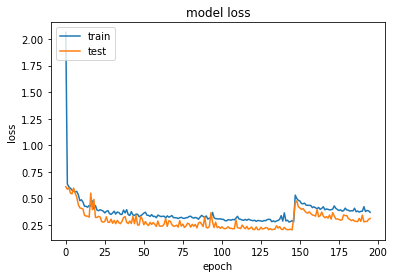

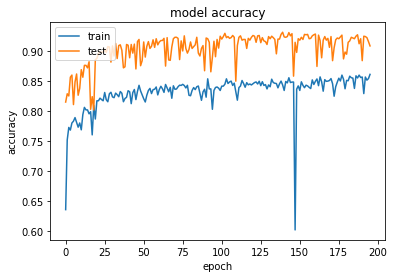

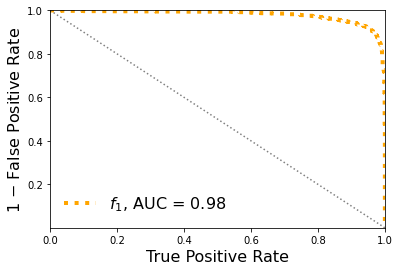

Classification score:


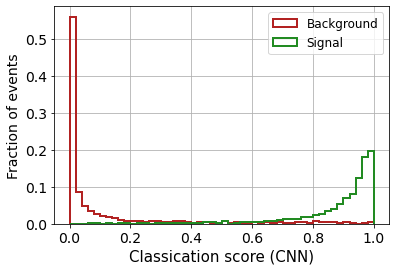


 ROC-AUC =  0.9790063147346688


In [53]:

# define the keras model
model = Sequential()
model.add(Conv1D(16, 2, input_shape=(X_mon_train.shape[1],1), activation='relu', strides = (1),kernel_regularizer=l2(0.005)))
model.add(MaxPooling1D(2, strides = (1)))
model.add(Conv1D(16, 2, input_shape=(X_mon_train.shape[1],1), activation='relu', strides = (1),kernel_regularizer=l2(0.005)))
model.add(MaxPooling1D(2, strides = (1)))
model.add(Flatten())
model.add(Dense(10, activation='relu'))
model.add(Dropout(0.20))
model.add(Dense(1, activation='sigmoid'))


# Print the model summary
#model.summary()

# to stop the training if validation loss does not improve after patience number of epochs
stop_training = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=50, restore_best_weights=True)

# compile the keras model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])


batch_size = 128
tot_epochs = 500


# Entrenamos el modelo
history = model.fit(X_mon_train_cn,
                    y_mon_train,
                    batch_size=batch_size,
                    epochs=tot_epochs,
                    callbacks=[stop_training],
                    verbose=1,
                    validation_data=(X_mon_val_cn, y_mon_val),
                    shuffle=True)


# Plot de la cost function para la train y test data
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.legend(['train', 'test'], loc='upper left')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.show()

# Plot de la accuracy function para la train y test data
plt.figure()
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()


#model.save(root_dir + 'CNN-histo-mix-v2/saved-models/' + 'conv-' + nameMIX_linear +'.h5') # Guardar el modelo.  # Predicción de la red entrenada
y_pred_cnn = model.predict(X_mon_test_cn)

# Compute ROC curve and ROC area for each class
fpr_cnn = dict()
tpr_cnn = dict()
roc_auc_cnn = dict()
fpr_cnn, tpr_cnn, _ = roc_curve(y_mon_test, y_pred_cnn)
roc_auc_cnn = auc(fpr_cnn, tpr_cnn)


plt.figure()
plt.plot(tpr_cnn,1-fpr_cnn,label="$f_{1}$, AUC = %0.2f" % roc_auc_cnn,color="orange",ls=":",lw=4)
plt.plot([1,0],[0,1],ls=":",color="grey")
plt.xlabel("True Positive Rate",fontsize=16)
plt.ylabel("1 $-$ False Positive Rate",fontsize=16)
plt.legend()
plt.xlim([0,1])
plt.ylim([0,1])
plt.yticks([0.2,0.4,0.6,0.8,1.])
plt.legend(frameon=False,fontsize=16)
plt.show()








########################
# CLASSIFICATION SCORE #
########################

# Outputs for validation data set

pred_XG_SM = []
pred_XG_NP = []

for i in range(len(y_mon_test)):
    if y_mon_test[i] == 0:
        pred_XG_SM.append(y_pred_cnn[i,0])
    else:
        pred_XG_NP.append(y_pred_cnn[i,0])
        
        
print('Classification score:')
        
weights = np.ones_like(pred_XG_SM)/float(len(pred_XG_SM))
nSM, binsSM, patchesSM = plt.hist(pred_XG_SM, 50, weights=weights, range=[0,1], histtype='step', color='firebrick', linewidth=2, label='Background')

weights = np.ones_like(pred_XG_NP)/float(len(pred_XG_NP))
nNP, binsNP, patchesNP = plt.hist(pred_XG_NP, 50, weights=weights, range=[0,1], histtype='step', color='forestgreen', linewidth=2, label='Signal')

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel("Classication score (CNN)",fontsize=15)
plt.ylabel("Fraction of events",fontsize=14)
plt.grid()
plt.legend(fontsize=12)

plt.show()






print('\n ROC-AUC = ', roc_auc_cnn)